# MSM UTIL

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import chi2
from pandas import DataFrame as df
from numpy import matlib
from scipy.optimize import fminbound, minimize, fsolve
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from datetime import date
#import winsound
from pylab import rcParams
import pickle
from datetime import date
from time import time
import statsmodels.api as sm

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## T_mat_temp

In [2]:
def T_mat_temp(kbar):
    """
    Build template for kbar
    :param kbar:
    :return:
    """
#     kbar = int(kbar)
    A = np.fromfunction(lambda i, j: i ^ j, (2**kbar, 2**kbar), dtype=int)
    A_temp = A.astype(float)
    return A_temp

## MSM_starting_values(data, startingvals, kbar):

In [3]:
def MSM_starting_values(data, startingvals, kbar, distribution, dof, send_out):
    """
    find starting values for params
    :param data:
    :param startingvals:
    :param kbar:
    :return:
    """

    # print('No starting values entered: Using grid-search')
    # A grid search used to find the best set of starting values in the
    # event none are supplied by the user
    
    if bool(startingvals):
        dum = startingvals[1]
        b = [1.5, 1.5 + (dum-1.5)/3, 1.5 + 2*(dum-1.5)/3, dum]
        lb = len(b)
        
        dum = startingvals[2]
        g = [0.01,dum-(dum-0.01)/2, (0.99-dum)/2+dum, .99]
        lg = len(g)
        sigma = startingvals[3]
        
    else :
        b = [1.5, 3, 6, 20]
        lb = len(b)
        g = [.01, .5, .99]
        lg = len(g)
        sigma = np.std(data, ddof=1) #* np.sqrt(252)
            
        
    

    LL_storage = df(columns=['LL', 'b', 'g', 'm','sigma'])
    m0_lower = 1.2
    m0_upper = 1.8

    index = 1

    # I know that adding one by one row on DF is quiet inefficient
    # I will try to use lambda, map instead of double for loop if I have a time

    for i in range(0, lb):
        for j in range(0, lg):
            a_m0 = fminbound(MSM_likelihood_new, 1.2, 1.8,
                             args=( b[i], g[j], sigma, kbar, data, distribution, dof, send_out), 
                             xtol=1e-05, maxfun=500, full_output=True)  # , disp=3)
            LL_storage.loc[len(LL_storage), 'LL'] = a_m0[1]
            LL_storage.loc[len(LL_storage) - 1, 'b'] = b[i]
            LL_storage.loc[len(LL_storage) - 1, 'g'] = g[j]
            LL_storage.loc[len(LL_storage) - 1, 'm'] = a_m0[0]

    LL_storage = LL_storage.sort_values(by=['LL'], ascending=True)
    LL_storage = LL_storage.reset_index(drop=True)
#     print(LL_storage)
    startingvals = [0., 0., 0., sigma]
    startingvals[1] = LL_storage.loc[0, 'b']
    startingvals[0] = LL_storage.loc[0, 'm']
    startingvals[2] = LL_storage.loc[0, 'g']

    return startingvals, LL_storage

## MSM_likelihood_new(*args):

In [4]:
def MSM_likelihood_new(*args, distribution = 'Normal', dof = 2, send_out = 'vol'):
    # TODO: เอา A ออกมาเป็น params แล้ว B = A.copy()
    # or  global A
    # แล้ว จัดการ A ต่อได้เลย
    
    """
    calculate LL for 3 cases (depend on number of input)
    :param args:
    :return:
    """

    if len(args) ==6 :
        # optimize -> minimizer
        print("len arg =3")
        inp = args[0]
        kbar = args[1]
        data = args[2]
        m0 = inp['m0'].value
        b = inp['b'].value
        gamma_k = inp['gamma_k'].value
        sigma = inp['sigma'].value
        distribution = args[3]
        dof = args[4]
        sendout = args[5]
        

    elif len(args) == 9 :
        # choose starting val -> fminbound
        print("len arg =9")
        m0 = args[0]
        b = args[1]
        gamma_k = args[2]
        sigma = args[3]
        kbar = args[4]
        data = args[5]
        distribution = args[6]
        dof = args[7]
        sendout = args[8]

    elif len(args) == 4 :
        # for outcome
        print("len arg =4")
        inp = args[0]
        kbar = args[1]
        data = args[2]
        m0 = inp['m0'].value
        b = inp['b'].value
        gamma_k = inp['gamma_k'].value
        sigma = inp['sigma'].value

    A_temp = T_mat_temp(kbar)
    k2 = 2 ** kbar
#     print("kbar = "+str(kbar))

    def transition_mat(A_temp, b, gamma_k, kbar):
        A = A_temp

        gamma = np.zeros((kbar, 1))
        gamma[0] = 1 - (1 - gamma_k) ** (1 / (b ** (kbar - 1)))

        def bitget(number, position):

            bi_number = bin(number)
            bi_number = bi_number[2:]
            if len(bi_number) >= position:

                fn_output = bi_number[-position]
            else:
                fn_output = 0

            return fn_output

        for i in range(1, kbar):
            gamma[i, 0] = 1 - (1 - gamma[0]) ** (b ** i)

        gamma = gamma / 2
        gamma = np.append(gamma, gamma, axis=1)
        gamma[:, 0] = 1 - gamma[:, 0]
        
         #print(gamma[:,1])
         #print(gamma[-1,1])

        kbar1 = kbar + 1
        kbar2 = 2 ** kbar

        prob = np.ones((kbar2, 1))

        for i in range(0, kbar2):
            for m in range(1, kbar + 1):
                prob[i, 0] = prob[i, 0] * gamma[kbar1 - m - 1, int(bitget(i, m))]

        for i in range(0, 2 ** (kbar - 1)):
            for j in range(i, 2 ** (kbar - 1)):
                A[kbar2 - i - 1, j] = prob[kbar2 - int(A[i, j]) - 1, 0]
                A[kbar2 - j - 1, i] = A[kbar2 - i - 1, j]
                A[j, kbar2 - i - 1] = A[kbar2 - i - 1, j]
                A[i, kbar2 - j - 1] = A[kbar2 - i - 1, j]

                A[i, j] = prob[int(A[i, j]), 0]
                A[j, i] = A[i, j]
                A[kbar2 - i - 1, kbar2 - j - 1] = A[i, j]
                A[kbar2 - j - 1, kbar2 - i - 1] = A[i, j]
        return A, gamma

    def gofm(m0, kbar):

        m1 = 2 - m0
        kbar2 = 2 ** kbar
        g_m1 = list(range(0, kbar2))
        for i in range(0, kbar2):
            g = 1
            for j in range(0, kbar):  # not req -1
                if g_m1[i] & 2 ** j != 0:
                    g = g * m1
                else:
                    g = g * m0
            g_m1[i] = g

        g_m = np.sqrt(g_m1)
        return g_m

    A, gamma = transition_mat(A_temp, b, gamma_k, kbar)
    g_m = gofm(m0, kbar)
    T = len(data)
    pi_mat = np.zeros((T + 1, k2))
    LLs = np.zeros((T,1))
    pi_mat[0, :] = (1 / k2) * np.ones((1, k2))

    # Likelihood Algorithm


    # g_m is binomial measure ?
    g_m = np.array(g_m).reshape((1, len(g_m)))
    # s is matrix of all volatility (sigma) state ?
    s = np.matlib.repmat(sigma * g_m, T, 1)


    data2 = np.array(data).reshape((len(data), 1))
    
    if distribution == 'Normal':
        pa = (2 * np.pi) ** (-0.5)
        w_t = np.matlib.repmat(data2, 1, k2)
        w_t = np.divide(pa * np.e ** (-0.5 * np.power(np.divide(w_t, s), 2)), s)
        w_t = w_t + 10 ** -16
        
    elif distribution == 'ChiSq':
        s=s**2 #test
        w_t = np.matlib.repmat(data2, 1, k2)
#         print("divide", np.divide(w_t, s),"\n")
        w_t = np.divide(chi2.pdf(np.divide(w_t, s) + 10**-25, dof), s)
        w_t = w_t + 10 ** -25
        
#     print(w_t)
        
        
    for t in range(0, T):
        piA = np.matmul(pi_mat[t, :], A)
        C = np.multiply(w_t[t, :], piA)
        
#         if t < 2:
#             print("piA = ", piA)
#             print(C)
            
        ft = sum(C)

        # stop div by zero if prob are too low
        if ft == 0:
            pi_mat[t + 1, :] = (1 / k2) * np.ones((1, k2))
            print("o(>\\\<)0 {!!!!!}")
        else:
            pi_mat[t + 1, :] = np.divide(C, ft)

        LLs[t] = np.log(np.dot(w_t[t, :], piA))

    LL = -sum(LLs)

    if np.isinf(LL):
        print('Log-likelihood is inf. Probably due to all zeros in pi_mat.')

    if (len(args) == 4) & (send_out == 'vol'):
        # Volatility prediction (single state)
        
        t_predict = args[3]
        vol = np.ones((t_predict,1))
        vol = vol.astype(float)
        state_now = pi_mat[-1 , :]
        
        for t in range(0,t_predict):
            vol[t,0] = sum(np.matmul(state_now, np.linalg.matrix_power(A, t+1)))*sigma
        
        return vol
    
    elif (len(args) == 4) & (send_out == 'forecast multistep'):
        # get state for multiple forecast time 
        
        return pi_mat, A, sigma, s
        
    else:
        return sum(LL)#+1/(2*gamma[-1,1])-1

## MSM_fitdata(data, kbar, LB ,UB, op_methods, startingvals):

In [5]:
def MSM_fitdata(data, kbar, LB ,UB, op_methods, startingvals, distribution , dof , send_out):
    """
    Combine MSM_likelihood_new, MSM_starting_values, T_mat_Temp
    :param data: Must be a column vector of a log return
    from latest day [index0 : 1 Jan 1974] to today [index -1 : 1 Jan 2018]
    multiply it with 100
    :param kbar:
    :param LB:
    :param UB:
    :param op_methods:
    :param startingvals:
    :return:
    """

    input_param, LLS = MSM_starting_values(data, startingvals, kbar, distribution, dof, send_out)
        # print('LL = %8.4f' % LLS.loc[0, 'LL'])
        
     #input_param = startingvals
    
    # create a set of Parameters
    params = Parameters()
    params.add('m0', value=input_param[0], min=LB[0], max=UB[0])
    params.add('b', value=input_param[1], min=LB[1], max=UB[1])
    params.add('gamma_k', input_param[2], min=LB[2], max=UB[2])
    params.add('sigma', value=input_param[3], min=LB[3], max=UB[3])

#     print("==========init params=========")
#     for element in params:
#         print(element + " = %8.4f" % (params[element].value))



    minner = Minimizer(MSM_likelihood_new, params, fcn_args=(kbar, data, distribution , dof , send_out))
    result = minner.minimize(method=op_methods)
    

#     print("\n\n ==========fitted results==========")
#     print('optimization method = ' + op_methods)
#     for element in result.params:
#         print(element + " = %8.4f" % (result.params[element].value))
#     print("\n")
    # print('LLs = %8.4f' % (result.residual))
    # print('AIC = %8.4f' % (result.aic))
    # print('BIC = %8.4f' % (result.bic))

    return result

## msm_fitseries(data, kbar, LB, UB, op_methods, startingvals, m, RV):
    

In [6]:
def msm_fitseries(data, kbar, LB, UB, op_methods, startingvals, m, RV):
    """
     series of MSM_fitdata for calculate step-by-step
    :param data: 
    :param kbar: 
    :param LB: 
    :param UB: 
    :param op_methods: OPTIMIZATION METHOD
    :param startingvals: 
    :param m: numbers of days we try to estimate
    :param RV: days to calculate RV
    :return: 
    """
    output = df()
    output["RV"] = []
    output["m0"] = []
    output["b"] = []
    output["gamma_k"] = []
    output["sigma"] = []

    for i in range(0, m):
        print("round" + str(i))
        data2 = data[i:len(data) - m + i]
        result = MSM_fitdata(data2, kbar, LB, UB, op_methods, startingvals)
        re2 = MSM_likelihood_new(result.params, kbar, data2, RV)
        output.loc[i, "RV"] = sum(re2) ** 2 * 100
        for element in result.params:
            output.loc[i, element] = result.params[element].value

    return output

# TEST FIT_PARAMS

## INPUT

In [112]:
filename = 'fed_data.xlsx'
xls = pd.ExcelFile(filename)
CA_raw = pd.read_excel(xls, 'CA')
DM_raw = pd.read_excel(xls, 'DM')
JA_raw = pd.read_excel(xls, 'JA')
UK_raw = pd.read_excel(xls, 'UK')

### construct a reaw data matrix

In [113]:
def T3(dum_data, Table3_Currency_Vol, row):
    returns = 100*np.log(1+dum_data['Column2'].pct_change().dropna())
    subperiod = 4
    Table3_Currency_Vol.loc[row,'Entire'] = float(np.std(returns))
    for i in range(0,subperiod):
        sub_data = dum_data['Column2']
        #print('i = ' + str(i))
        #print('from : ',int(np.floor(i*len(returns)/subperiod)))
        #print('to   : ',int(np.floor((i+1)*len(returns)/subperiod)))
        sub_data = sub_data.iloc[int(np.floor(i*len(returns)/subperiod)):int(np.floor((i+1)*len(returns)/subperiod))]
        returns2 = 100*np.log(1+sub_data.pct_change().dropna())
        Table3_Currency_Vol.iloc[row,i+1] = float(np.std(returns2))
        
    return Table3_Currency_Vol


In [114]:
Table3_Currency_Vol = df()
Table3_Currency_Vol['Entire']=[]
Table3_Currency_Vol['Sub1']=[]
Table3_Currency_Vol['Sub2']=[]
Table3_Currency_Vol['Sub3']=[]
Table3_Currency_Vol['Sub4']=[]

raw = [DM_raw, JA_raw, UK_raw, CA_raw]
for row in range(0, len(raw)):
    Table3_Currency_Vol = T3(raw[row], Table3_Currency_Vol, row)
Table3_Currency_Vol

,Entire,Sub1,Sub2,Sub3,Sub4
0,0.664101,0.586819,0.716642,0.708206,0.635449
1,0.656566,0.544619,0.639886,0.645119,0.775137
2,0.606847,0.485806,0.724471,0.699407,0.472817
3,0.274376,0.220132,0.254553,0.284356,0.326698


### plot to see data

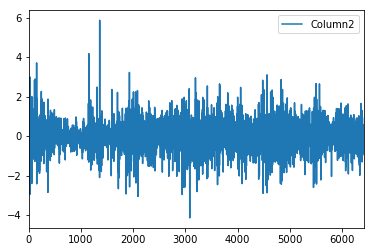

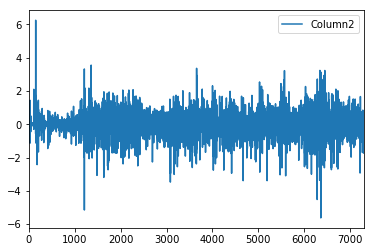

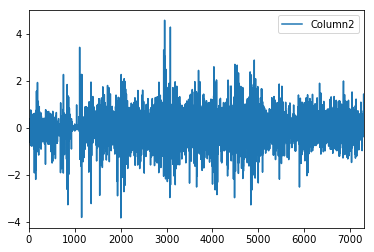

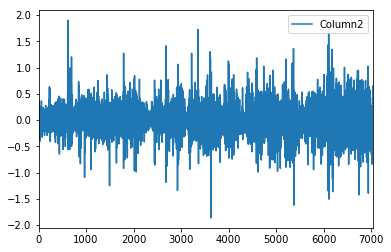

In [115]:
# rcParams['figure.figsize'] = 5, 10

for row in range(0, len(raw)):
    dum_data = raw[row]
    returns = 100*np.log(1+dum_data['Column2'].pct_change().dropna())
    a = returns.to_frame()
    a.plot()

plt.show()

## OUTPUT

#### Construct a output dataframe for store hard working parameters

In [116]:
output = df()
output["m0"] = []
output["b"] = []
output["gamma_k"]=[]
output["sigma"] = []
output["LL"] = []
result = []

startingvals = []#[1.2, 1.2, 0.5 , 1.2 ]
LB = [1, 1, 0.001, 0.0001]
UB = [1.99, 50, 0.99999, 50]

### DM

In [63]:
op_methods = 'slsqp'
row = 0
dum_data = raw[row]
returns = np.log(1+dum_data['Column2'].pct_change().dropna())
a = returns.to_frame()
data = a['Column2']*100
data2 = data#[::-1]
startingvals = []

for i in range(0,10):
    kbar = i+1
    if kbar >1 and bool(result):
        startingvals = [result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value]
    result = MSM_fitdata(data, kbar, LB ,UB,op_methods, startingvals)
    re2 = MSM_likelihood_new(result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value,  kbar, data2)
    output.loc[i,"LL"] = re2
    for element in result.params:
        output.loc[i,element] = result.params[element].value
        
writer = pd.ExcelWriter('Output'.join((date.today().strftime('%y%m%d'),op_methods+'DMvaryk.xlsx')))
output.to_excel(writer, 'Sheet1')
writer.save()
        
output  

         LL    b     g        m sigma
0   5924.15  1.5   0.1  1.66418   NaN
1   5924.15    3   0.1  1.66418   NaN
2   5924.15    6   0.1  1.66418   NaN
3   5924.15   20   0.1  1.66418   NaN
4   6029.55  1.5   0.5  1.74141   NaN
5   6029.55    3   0.5  1.74141   NaN
6   6029.55    6   0.5  1.74141   NaN
7   6029.55   20   0.5  1.74141   NaN
8   6135.42  1.5  0.99  1.73377   NaN
9   6135.42    3  0.99  1.73377   NaN
10  6135.42    6  0.99  1.73377   NaN
11  6135.42   20  0.99  1.73377   NaN
==========init params=========
m0 =   1.6642
b =   1.5000
gamma_k =   0.1000
sigma =   0.6642


 ==========fitted results==========
optimization method = slsqp
m0 =   1.6541
b =   1.5000
gamma_k =   0.0747
sigma =   0.6819


         LL    b          g        m sigma
0   5794.83  1.5  0.0747172  1.57793   NaN
1   5794.83  1.5  0.0747172  1.57793   NaN
2   5794.83  1.5  0.0747172  1.57793   NaN
3   5794.83  1.5  0.0747172  1.57793   NaN
4   5959.69  1.5   0.532359  1.62232   NaN
5   5959.69  1.5   0.53

,m0,b,gamma_k,sigma,LL
0,1.654133,1.500000,0.074717,0.681917,5920.855214
1,1.589895,8.016456,0.106826,0.650560,5782.955933
2,1.554623,21.914346,0.672529,0.600255,5731.776138
3,1.491546,10.420285,0.713536,0.571605,5715.300200
4,1.461936,7.886674,0.750633,0.511672,5708.240226
5,1.412923,5.160288,0.858273,0.537734,5706.903687
6,1.379843,4.117634,0.931533,0.546732,5704.470829
7,1.352666,3.381746,0.973716,0.550389,5704.765369
8,1.330602,2.850096,0.972934,0.560066,5705.342737
9,1.325676,2.702472,0.958863,0.643250,5705.085364


### JPY

In [64]:
op_methods = 'slsqp'
row = 1
dum_data = raw[row]
returns = np.log(1+dum_data['Column2'].pct_change().dropna())
a = returns.to_frame()
data = a['Column2']*100
data2 = data#[::-1]
startingvals = []

for i in range(0,10):
    kbar = i+1
    if kbar >1 and bool(result):
        startingvals = [result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value]
    result = MSM_fitdata(data, kbar, LB ,UB,op_methods, startingvals)
    re2 = MSM_likelihood_new(result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value,  kbar, data2)
    output.loc[i,"LL"] = re2
    for element in result.params:
        output.loc[i,element] = result.params[element].value
        
writer = pd.ExcelWriter('Output'.join((date.today().strftime('%y%m%d'),op_methods+'JPYvaryk.xlsx')))
output.to_excel(writer, 'Sheet1')
writer.save()
        
output  

         LL    b     g        m sigma
0   6474.43  1.5   0.1  1.75145   NaN
1   6474.43    3   0.1  1.75145   NaN
2   6474.43    6   0.1  1.75145   NaN
3   6474.43   20   0.1  1.75145   NaN
4   6506.28  1.5   0.5  1.79999   NaN
5   6506.28    3   0.5  1.79999   NaN
6   6506.28    6   0.5  1.79999   NaN
7   6506.28   20   0.5  1.79999   NaN
8   6657.16  1.5  0.99  1.79999   NaN
9   6657.16    3  0.99  1.79999   NaN
10  6657.16    6  0.99  1.79999   NaN
11  6657.16   20  0.99  1.79999   NaN
==========init params=========
m0 =   1.7514
b =   1.5000
gamma_k =   0.1000
sigma =   0.6566


 ==========fitted results==========
optimization method = slsqp
m0 =   1.7969
b =   1.5000
gamma_k =   0.1989
sigma =   0.6298


         LL    b         g        m sigma
0   6198.81  1.5  0.198939  1.71102   NaN
1   6198.81  1.5  0.198939  1.71102   NaN
2   6198.81  1.5  0.198939  1.71102   NaN
3   6198.81  1.5  0.198939  1.71102   NaN
4   6368.15  1.5  0.594469  1.71573   NaN
5   6368.15  1.5  0.594469  1

,m0,b,gamma_k,sigma,LL
0,1.796889,1.500000,0.198939,0.629831,6451.792036
1,1.776111,50.000000,0.326086,0.542971,6106.053752
2,1.693020,12.457074,0.311943,0.565602,5959.710137
3,1.654031,15.584963,0.697383,0.461888,5900.663844
4,1.586325,8.717936,0.869250,0.464081,5883.238714
5,1.534078,6.296554,0.956450,0.466958,5875.473759
6,1.527624,6.006854,0.966087,0.391437,5870.013921
7,1.512750,5.649653,0.974797,0.513890,5863.189012
8,1.475161,4.430843,0.995420,0.486330,5862.997348
9,1.448112,3.761698,0.997645,0.461049,5862.674907


### GBP

In [117]:
kbar >1 and bool([])

False

In [89]:
op_methods = 'slsqp'
row = 2
dum_data = raw[row]
returns = np.log(1+dum_data['Column2'].pct_change().dropna())
a = returns.to_frame()
data = a['Column2']*100
data2 = data#[::-1]
startingvals = []


for i in range(0,10):
    kbar = i+1
    print(kbar)
    
    if kbar >1 and bool(result):
        startingvals = [result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value]
    
    result = MSM_fitdata(data, kbar, LB ,UB,op_methods, startingvals)
    re2 = MSM_likelihood_new(result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value,  kbar, data2)
    output.loc[i,"LL"] = re2
    for element in result.params:
        output.loc[i,element] = result.params[element].value
        
writer = pd.ExcelWriter('Output'.join((date.today().strftime('%y%m%d'),op_methods+'GBPvaryk5.xlsx')))
output.to_excel(writer, 'Sheet1')
writer.save()
        
output  

1
         LL    b     g        m sigma
0   5960.39  1.5   0.1  1.71092   NaN
1   5960.39    3   0.1  1.71092   NaN
2   5960.39    6   0.1  1.71092   NaN
3   5960.39   20   0.1  1.71092   NaN
4   6042.08  1.5   0.5  1.79291   NaN
5   6042.08    3   0.5  1.79291   NaN
6   6042.08    6   0.5  1.79291   NaN
7   6042.08   20   0.5  1.79291   NaN
8   6195.76  1.5  0.99  1.78486   NaN
9   6195.76    3  0.99  1.78486   NaN
10  6195.76    6  0.99  1.78486   NaN
11  6195.76   20  0.99  1.78486   NaN
==========init params=========
m0 =   1.7109
b =   1.5000
gamma_k =   0.1000
sigma =   0.6069


 ==========fitted results==========
optimization method = slsqp
m0 =   1.7157
b =   1.5000
gamma_k =   0.1099
sigma =   0.6087


2
         LL    b         g        m sigma
0   5766.16  1.5  0.109946  1.65469   NaN
1   5766.16  1.5  0.109946  1.65469   NaN
2   5766.16  1.5  0.109946  1.65469   NaN
3   5766.16  1.5  0.109946  1.65469   NaN
4   5938.49  1.5  0.549973  1.67616   NaN
5   5938.49  1.5  0.54997

,m0,b,gamma_k,sigma,LL
0,1.715749,1.500000,0.109946,0.608671,5960.169424
1,1.671453,19.905125,0.222162,0.589502,5724.358738
2,1.647739,14.286373,0.277987,0.513368,5622.725978
3,1.609153,12.506440,0.644940,0.467186,5570.014433
4,1.578921,11.017527,0.637128,0.421256,5537.792457
5,1.533702,8.315625,0.783474,0.467635,5523.628778
6,1.503309,6.715476,0.811321,0.389147,5516.877211
7,1.460527,5.232527,0.958404,0.383777,5515.366208
8,1.428160,4.075240,0.964411,0.373594,5515.268775
9,1.402960,3.450710,0.981753,0.370389,5514.933868


### CAD

In [90]:
op_methods = 'slsqp'
row = 3
dum_data = raw[row]
returns = np.log(1+dum_data['Column2'].pct_change().dropna())
a = returns.to_frame()
data = a['Column2']*100
data2 = data#[::-1]
startingvals = []

for i in range(0,10):
    kbar = i+1
    if kbar >1 and bool(result):
        startingvals = [result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value]
    result = MSM_fitdata(data, kbar, LB ,UB,op_methods, startingvals)
    re2 = MSM_likelihood_new(result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value,  kbar, data2)
    output.loc[i,"LL"] = re2
    for element in result.params:
        output.loc[i,element] = result.params[element].value

writer = pd.ExcelWriter('Output'.join((date.today().strftime('%y%m%d'),op_methods+'CADvaryk.xlsx')))
output.to_excel(writer, 'Sheet1')
writer.save()

output  

         LL    b     g        m sigma
0   277.435  1.5   0.1  1.66057   NaN
1   277.435    3   0.1  1.66057   NaN
2   277.435    6   0.1  1.66057   NaN
3   277.435   20   0.1  1.66057   NaN
4   422.325  1.5   0.5  1.71418   NaN
5   422.325    3   0.5  1.71418   NaN
6   422.325    6   0.5  1.71418   NaN
7   422.325   20   0.5  1.71418   NaN
8   550.776  1.5  0.99  1.69648   NaN
9   550.776    3  0.99  1.69648   NaN
10  550.776    6  0.99  1.69648   NaN
11  550.776   20  0.99  1.69648   NaN
==========init params=========
m0 =   1.6606
b =   1.5000
gamma_k =   0.1000
sigma =   0.2744


 ==========fitted results==========
optimization method = lbgfsb
m0 =   1.6459
b =   1.8901
gamma_k =   0.0638
sigma =   0.2799


         LL        b         g        m sigma
0   143.498  1.89008  0.063751  1.54284   NaN
1   144.306  1.76005  0.063751  1.54288   NaN
2   145.193  1.63003  0.063751  1.54297   NaN
3   146.169      1.5  0.063751  1.54314   NaN
4   331.158  1.89008  0.526876  1.58396   NaN
5   

,m0,b,gamma_k,sigma,LL
0,1.645898,1.890077,0.063751,0.279945,271.002919
1,1.555995,10.924122,0.109383,0.277510,129.793835
2,1.473888,4.758877,0.128981,0.292861,105.152252
3,1.435084,3.948461,0.170709,0.263496,91.314827
4,1.386468,4.022594,0.441384,0.251030,88.401337
5,1.373756,4.075756,0.523879,0.294691,84.719261
6,1.337553,3.111044,0.593339,0.281890,84.022924
7,1.319242,2.723327,0.594994,0.262433,83.389001
8,1.295804,2.350653,0.630917,0.259362,83.046985
9,1.277733,2.108387,0.643876,0.261617,82.989752


## export set of params to .xlsx

In [118]:
output

,m0,b,gamma_k,sigma,LL


In [119]:
name = 'GBP'
name_L = 'Output'.join((date.today().strftime('%y%m%d'),op_methods+name+'5.xlsx'))
writer = pd.ExcelWriter(name_L)
print(name_L)
output.to_excel(writer, 'Sheet1')
writer.save()

180327OutputslsqpGBP5.xlsx


# Verify likelihood function

In [120]:
op_methods = 'lbfgsb'
row = 1
dum_data = raw[row]
returns = np.log(1+dum_data['Column2'].pct_change().dropna())
returns = returns
a = returns.to_frame()
data = a['Column2']

MSM_likelihood_new(1.782,134.2,0.345,0.538, 2, data*100)

TypeError: 'float' object is not subscriptable

# Fit data

## FIT for forecast

In [39]:
row = 0
op_methods = 'slsqp'
predict_period = 1
kbar = 10

starting_index = 3000
dum_data = raw[row]
returns = np.log(1+dum_data['Column2'].pct_change().dropna())
a = returns.to_frame()
data = a['Column2']*100
LB = [1, 1, 0.001, 0.0001]
UB = [1.99, 50, 0.99999, 50]
startingvals = []
data_fit = data[:starting_index]

# fit params

result = MSM_fitdata(data_fit, kbar, LB ,UB,op_methods, startingvals)
#re2 = MSM_likelihood_new(result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value,  kbar, data_fit)
rez = result.params

KeyboardInterrupt: 

### Chain forecast

In [ ]:
row = 3
op_methods = 'slsqp'
predict_period = 1

starting_index = 3000
dum_data = raw[row]
returns = np.log(1+dum_data['Column2'].pct_change().dropna())
a = returns.to_frame()
data = a['Column2']*100
LB = [1, 1, 0.001, 0.0001]
UB = [1.99, 50, 0.99999, 50]
startingvals = []
data_fit = data[:starting_index]

# fit params

for i in range(0,10):
    kbar = i+1
    if kbar >1 and bool(result):
        startingvals = [result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value]
    result = MSM_fitdata(data_fit, kbar, LB ,UB,op_methods, startingvals)
    rez = result.params
    re2 = MSM_likelihood_new(result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,
                             result.params['sigma'].value,  kbar, data_fit
                            )
    output.loc[i,"LL"] = re2
    for element in result.params:
        output.loc[i,element] = result.params[element].value

In [ ]:
pi_mat, A, sigma, s = MSM_likelihood_wantto_forecast(rez, kbar, data, predict_period)

## PICKLE for import/export model

### save

In [ ]:
import pickle
from datetime import date
# obj0, obj1, obj2 are created here...

data_name = 'DM'
model_name = ''.join((date.today().strftime('%y%m%d'),"_"+ str(kbar)+ op_methods+ str(data_name) + '.pkl'))
# Saving the objects:
with open(model_name, 'wb') as f: 
    pickle.dump(result.params, f)
    print(model_name)


### load

In [ ]:
import pickle
# # Getting back the objects:
with open('180219_10slsqpDM.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    rez_2 = pickle.load(f)

In [ ]:
rez

In [ ]:
rez_2

## forecast process 1 day 

In [ ]:
# df for OLS
Pdict = df()
Pdict["vol"] = []
predict_period = 1

vol = np.ones((predict_period,1))
vol = vol.astype(float)
for i in range(starting_index,len(pi_mat)-1):
    
    state_now = pi_mat[i , :]
    for t in range(0,predict_period):
        vol[t,0] = np.inner(np.matmul(state_now, np.linalg.matrix_power(A, t+1)),s[1,:])
    Pdict.loc[i,"vol"] = sum(vol)

In [ ]:
returns = np.log(1+dum_data['Column2'].pct_change().dropna())
a = returns.to_frame()
data = a['Column2']*100
rsq = data[starting_index-2:].shift(-predict_period)
dfrsq = rsq.to_frame()
Pdict['real']=dfrsq**2
Pdict

In [36]:
rsq = data[starting_index-2:]**2
rsq

2999    0.127299
3000    0.001578
3001    0.311108
3002    1.419519
3003    0.303802
3004    0.954062
3005    0.434004
3006    2.071969
3007    2.371633
3008    1.316507
3009    0.055844
3010    0.759151
3011    0.177033
3012    0.110339
3013    0.014044
3014    1.389559
3015    0.006108
3016    2.407529
3017    0.331438
3018    5.251678
3019    0.620733
3020    0.000000
3021    0.024187
3022    1.013223
3023    0.214667
3024    1.810096
3025    0.118497
3026    0.005876
3027    0.442175
3028    1.173901
          ...   
7269    0.057591
7270    0.009201
7271    0.018822
7272    0.020750
7273    0.091236
7274    0.048297
7275    0.078888
7276    0.015181
7277    0.141379
7278    0.041991
7279    0.000421
7280    0.013533
7281    0.045148
7282    0.016974
7283    0.005678
7284    0.001687
7285    0.269198
7286    0.016716
7287    0.000740
7288    0.031190
7289    0.101417
7290    0.336519
7291    0.001131
7292    0.533191
7293    0.001113
7294    0.210995
7295    0.143872
7296    2.0821

## Regression

### stats model

In [ ]:
import statsmodels.api as sm

print('dataset = %1.0f' %row)

for ele in rez:
    print(ele,' = %8.4f'  %rez[ele].value)
x = Pdict.loc[:,'vol'].values.reshape(len(Pdict),1)
y = Pdict['real']

x2 = sm.add_constant(x)
est = sm.OLS(y, x2)
est2 = est.fit()
print(est2.summary())
# print("MODEL MSE",est2.mse_model)
print("MODEL MSE",est2.mse_resid)
print("MODEL TSE",est2.mse_total)

## EXPORT Result!

In [ ]:
# output = df()
# 

In [ ]:
for element in result.params:
    output.loc[row,element] = result.params[element].value

output.loc[row,'Slope'] = sum(regr.coef_)
output.loc[row,'intercept'] =  regr.intercept_
output.loc[row,'MSE'] = mean_squared_error(y, x)
output.loc[row,'R_sq'] = r2_score(y, x)

writer = pd.ExcelWriter('Output'.join((date.today().strftime('%y%m%d'),'ALL_REG.xlsx')))
output.to_excel(writer, 'Sheet1')
writer.save()

In [ ]:
result.params

In [ ]:
output

# Gold Data

## input

In [ ]:
GLD.loc[8000,:]

In [ ]:
GVZ = pd.read_excel('Data_GVZ_GLD_long.xlsx','GVZ')
GLD = pd.read_excel('Data_GVZ_GLD_long.xlsx','GLD')

GLD_r = GLD.loc[:,'log return'].dropna()
GLD_date = GLD.loc[:,'Date'].dropna()
GLD_data = GLD.loc[:,'index'].dropna()

plt.plot(GLD_date.iloc[:-1],200*GLD_r)
plt.plot(GLD_date,GLD_data)
plt.title('GLD data')


data = GLD_r[::-1]
data = data.reset_index(drop = True)
plt.show()

## output 

In [121]:
output = df()
output["m0"] = []
output["b"] = []
output["gamma_k"]=[]
output["sigma"] = []
output["LL"] = []
result = []

startingvals = []#[1.2, 1.2, 0.5 , 1.2 ]
LB = [1, 1, 0.001, 0.0001]
UB = [1.99, 50, 0.99999, 50]

In [122]:
data = data[3000:]

## Fit data

In [123]:
op_methods = 'slsqp'
data2 = data#[::-1]
startingvals = []

for i in range(0,10):
    kbar = i+1
    if kbar >1 and bool(result):
        startingvals = [result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value]
    result = MSM_fitdata(data, kbar, LB ,UB,op_methods, startingvals)
    re2 = MSM_likelihood_new(result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value,  kbar, data2)
    output.loc[i,"LL"] = re2
    for element in result.params:
        output.loc[i,element] = result.params[element].value
        
writer = pd.ExcelWriter('Output'.join((date.today().strftime('%y%m%d'),op_methods+'GLDvaryk.xlsx')))
output.to_excel(writer, 'Sheet1')
writer.save()
        
output

TypeError: MSM_fitdata() missing 3 required positional arguments: 'distribution', 'dof', and 'send_out'

# GLD Forecast

### drop index 

In [124]:
GVZ_date = GVZ.loc[:,'Date'].dropna()
GVZ_data = GVZ.loc[:,'index'].dropna()
GLD_date = GLD.loc[:,'Date'].dropna()
GLD_data = GLD.loc[:,'index'].dropna()

# GVZ/GLD use for regression (new -> old)
GVZ_date = GVZ_date.drop(GVZ_date.index[0])
GVZ_date = GVZ_date.reset_index(drop=True)
# for small date
GVZ_date = GVZ_date[0:1000]
GVZ_data = GVZ_data.reset_index(drop=True)

GLD_data = GLD_data.drop(GLD_date.index[0])
GLD_data = GLD_data.reset_index(drop=True)
GLD_date = GLD_date.drop(GLD_date.index[0])
GLD_date = GLD_date.drop(GLD_date.index[len(GLD_date)-1])
GLD_date = GLD_date.reset_index(drop=True)

# all to df
df_reg = GVZ_date.to_frame()
df_reg["GVZ"] = GVZ_data
df_reg["GLD"] = GLD_data

# [old -> new]
df_reg = df_reg[::-1]
# df_reg

# New data drop the first (last date) because there are no GVZ data
# data use for MSM function (old -> new)
data = GLD_r
data = data.drop(data.index[len(data)-1])
data = data.reset_index(drop=True)
data_fit = data.drop(data.index[0:len(df_reg)])


KeyError: 'the label [Date] is not in the [columns]'

## chain forecast

### param

In [125]:
op_methods = 'slsqp'
predict_period = 1
kbar = 10
LB = [1, 1, 0.001, 0.0001]
UB = [1.99, 50, 0.99999, 50]
startingvals = []

### fit param

In [126]:
# fit params
for i in range(0,10):
    kbar = i+1
    if kbar >1 and bool(result):
        startingvals = [result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value]
    result = MSM_fitdata(data_fit, kbar, LB ,UB,op_methods, startingvals)
    rez = result.params
    re2 = MSM_likelihood_new(result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,
                             result.params['sigma'].value,  kbar, data_fit
                            )
    output.loc[i,"LL"] = re2
    for element in result.params:
        output.loc[i,element] = result.params[element].value

NameError: name 'data_fit' is not defined

## save params

In [127]:
import pickle
from datetime import date
# obj0, obj1, obj2 are created here...

data_name = 'GLD'
model_name = ''.join((date.today().strftime('%y%m%d'),"_"+ str(kbar)+ op_methods+ str(data_name) + '.pkl'))
# Saving the objects:
with open(model_name, 'wb') as f: 
    pickle.dump(result.params, f)
    print(model_name)


AttributeError: 'list' object has no attribute 'params'

### load params

In [128]:
import pickle
# # Getting back the objects:
kbar = 10
with open('180225_10slsqpGLD.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    rez_2 = pickle.load(f)

In [129]:
rez = rez_2

## get forecast params

In [130]:
predict_period = -1
pi_mat, A, sigma, s = MSM_likelihood_wantto_forecast(rez, kbar, data, predict_period)

NameError: name 'MSM_likelihood_wantto_forecast' is not defined

## forecast 1 day

In [131]:
len(data2)

4298

In [132]:
len(data)

4298

In [133]:
# df for OLS
starting_index = len(data)-len(df_reg)
predict_period = 30
from time import time

t1 = time()
Pdict = df()
Pdict["vol"] = []
df_reg["vol"] = 0.


vol = np.ones((predict_period,1))
vol = vol.astype(float)
for i in range(starting_index+1,len(pi_mat)-1):
    state_now = pi_mat[i , :]
    for t in range(0,predict_period):
        vol[t,0] = np.inner(np.matmul(state_now, np.linalg.matrix_power(A, t+1)),s[1,:])
    df_reg.loc[len(pi_mat)-i-2,"vol"] = sum(vol)
print("TIME : %2.5f" %(time() - t1)) 
#     Pdict.loc[i,"vol"] = sum(vol)

KeyboardInterrupt: 

### save forcast data

In [ ]:
name = 'GVZreg'+str(predict_period)
name_L = 'Output'.join((date.today().strftime('%y%m%d'),name+'.xlsx'))
writer = pd.ExcelWriter(name_L)
print(name_L)
df_reg.to_excel(writer, 'Sheet1')
writer.save()

### load forecast data

In [ ]:
filename = '180301OutputGVZreg30.xlsx' # '180310OutputGVZreg1.xlsx' 180312OutputGVZreg30.xlsx
xls = pd.ExcelFile(filename)
df_reg = pd.read_excel(xls)

## Regression

In [ ]:
df_reg

In [ ]:
df_reg

### y= mx +c ; y as GVZ

In [ ]:
import statsmodels.api as sm

# print('dataset = %1.0f' %row)

for ele in rez:
    print(ele,' = %8.4f'  %rez[ele].value)

x = df_reg.loc[:,'vol'].values.reshape(len(df_reg),1)
y = df_reg['GVZ']

x2 = sm.add_constant(x)
est = sm.OLS(y, x2)
est2 = est.fit()
print(est2.summary())
# print("MODEL MSE",est2.mse_model)
print("MODEL MSE",est2.mse_resid)
print("MODEL TSE",est2.mse_total)

### y= mx ; y as GVZ

In [ ]:
est = sm.OLS(y, x)
est2 = est.fit()
print(est2.summary())
print("MODEL MSE",est2.mse_resid)
print("MODEL TSE",est2.mse_total)

### change y to realized vol

In [ ]:
y = (np.log(1+df_reg["GLD"].pct_change().dropna())*100)**2

In [ ]:
plt.hist(np.sqrt(y))
plt.show()

In [ ]:
x = df_reg.loc[2443:,'vol'].values.reshape(len(df_reg)-1,1)

x2 = sm.add_constant(x)
est = sm.OLS(y, x2)
est2 = est.fit()
print(est2.summary())
# print("MODEL MSE",est2.mse_model)
print("MODEL MSE",est2.mse_resid)
print("MODEL TSE",est2.mse_total)

### reg y:realize x:1dayvol

In [ ]:
df_reg

In [ ]:
y = (np.log(1+df_reg["GLD"].pct_change().dropna())*100)**2

In [ ]:
x = df_reg.loc[2443:,'vol'].values.reshape(len(df_reg)-1,1)

x2 = sm.add_constant(x)
est = sm.OLS(y, x2)
est2 = est.fit()
print(est2.summary())
# print("MODEL MSE",est2.mse_model)
print("MODEL MSE",est2.mse_resid)
print("MODEL TSE",est2.mse_total)

> The result told me that I can't use MSM with Gold price processes.

REALLY?


In [ ]:
Data

13/03/2018


# IMPORT gold spx oil DATA

## input

### read data

In [9]:
Data = pd.read_excel('all_3_data2.xlsx','Sheet2')

In [54]:
Data

,Dates,GOLDS,GVZ,SPX,VIX,CL1,OVX
0,1974-12-31,183.85,NaN,67.65,NaN,NaN,NaN
1,1975-01-01,183.85,NaN,66.91,NaN,NaN,NaN
2,1975-01-02,175.00,NaN,65.96,NaN,NaN,NaN
3,1975-01-03,174.00,NaN,66.88,NaN,NaN,NaN
4,1975-01-06,173.50,NaN,66.88,NaN,NaN,NaN
5,1975-01-07,169.50,NaN,67.44,NaN,NaN,NaN
6,1975-01-08,180.00,NaN,67.14,NaN,NaN,NaN
7,1975-01-09,179.00,NaN,67.16,NaN,NaN,NaN
8,1975-01-10,177.25,NaN,68.56,NaN,NaN,NaN
9,1975-01-13,180.25,NaN,68.56,NaN,NaN,NaN


### dynamic execution of Python code.

In [10]:
asset = ('GOLDS', 'GVZ', 'SPX', 'VIX', 'CL1', 'OVX')#('GLD', 'GVZ', 'SPX', 'VIX', 'USO', 'OVX')
for i in range(0,len(asset)):
    exec( eval("asset["+str(i)+"]") +"= Data.loc[:,('Dates',"+"asset["+str(i)+"])]" )
    exec( eval("asset["+str(i)+"]") +"_r=100*np.log(1+"+ str(eval("asset["+str(i)+"]")+".iloc[:,1]")+".pct_change().dropna())" )
    exec( eval("asset["+str(i)+"]") +"="+ eval("asset["+str(i)+"]")+".dropna()" )

In [11]:
print("GOLDS len : " + str(len(GOLDS)) +'\n' +
      "GVZ   len : " + str(len(GVZ)) +'\n' +
      "SPX   len : " + str(len(SPX)) +'\n' +
      "VIX   len : " + str(len(VIX)) +'\n' +
      "CL1   len : " + str(len(CL1)) +'\n' +
      "OVX   len : " + str(len(OVX)) +'\n' )

GOLDS len : 11279
GVZ   len : 2551
SPX   len : 11279
VIX   len : 7356
CL1   len : 9128
OVX   len : 2829



### plot

In [ ]:
for i in (0,2,4):
    fig,ax1 = plt.subplots()
    eval("ax1.plot("+eval('''asset['''+str(i)+''']''')+".loc[:,'Dates'],"+eval('''asset['''+str(i)+''']''')+".iloc[:,1],'b-')")
    ax2 = ax1.twinx()
    eval("ax2.plot("+eval('''asset['''+str(i)+''']''')+".iloc[1:,0],"+eval('''asset['''+str(i)+''']''')+"_r**2,color = 'tab:red', alpha = 0.5)")
    eval("ax2.plot("+eval('''asset['''+str(i+1)+''']''')+".iloc[1:,0],"+eval('''asset['''+str(i+1)+''']''')+".iloc[1:,1],color = 'tab:red', alpha = 1)")
    plt.title(eval('''asset['''+str(i)+''']''')+' data')


# data = GLD_r[::-1]
# data = data.reset_index(drop = True)
plt.show()

## Fit data

In [ ]:
for i in (0,2,4):
    name = eval('''asset['''+str(i)+''']''')
    exec( "data =" + eval('''asset['''+str(i)+''']''')+"_r" )
    distribution = "Normal"
    dof = 1 # for Chi**2 only
    send_out = "vol"
    
    output = df()
    output["m0"] = []
    output["b"] = []
    output["gamma_k"]=[]
    output["sigma"] = []
    output["LL"] = []
    result = []

    startingvals = []#[1.2, 1.2, 0.5 , 1.2 ]
    LB = [1, 1, 0.001, 0.0001]
    UB = [1.99, 50, 0.99999, 50]
    
    op_methods = 'slsqp'
    data2 = data

    for i in range(0,10):
        kbar = i+1
        if kbar >1 and bool(result):
            startingvals = [result.params['m0'].value,result.params['b'].value,
                            result.params['gamma_k'].value,result.params['sigma'].value]
        result = MSM_fitdata(data, kbar, LB, UB, op_methods, startingvals, distribution, dof, send_out)
         
        re2 = MSM_likelihood_new(result.params['m0'].value, result.params['b'].value,
                                 result.params['gamma_k'].value, result.params['sigma'].value, kbar, data2,
                                 distribution, dof, send_out)
        output.loc[i,"LL"] = re2
        for element in result.params:
            output.loc[i,element] = result.params[element].value
        
    writer = pd.ExcelWriter('Output'.join((date.today().strftime('%y%m%d'),op_methods+name+'varyk.xlsx')))
    output.to_excel(writer, 'Sheet1')
    writer.save()
    

# Forecast new 3 

## Train data

In [ ]:
Data

In [47]:
maxlen = 3000

In [ ]:
distribution = "Normal"
dof = 1 # for Chi**2 only
send_out = "vol"
    
for j in (0,2,4):
    
    # this step use partial data
    

    name = eval('''asset['''+str(j)+''']''')
    exec( "data =" + eval('''asset['''+str(j)+''']''')+"_r" )
    exec( "data_y =" + eval('''asset['''+str(j+1)+''']''') )
    
    if len(data_y) > maxlen :
        data_y = data_y.iloc[-maxlen:,1]
    else :
        data_y = data_y.iloc[:,1]

    data = data.iloc[:len(data)-len(data_y)]
            
    output = df()
    output["m0"] = []
    output["b"] = []
    output["gamma_k"]=[]
    output["sigma"] = []
    output["LL"] = []
    result = []

    startingvals = []#[1.2, 1.2, 0.5 , 1.2 ]
    LB = [1, 1, 0.001, 0.0001]
    UB = [1.99, 50, 0.99999, 50]
    
    op_methods = 'slsqp'
    data2 = data

    for i in range(0,10):
        kbar = i+1
        if kbar >1 and bool(result):
            startingvals = [result.params['m0'].value,result.params['b'].value,
                            result.params['gamma_k'].value,result.params['sigma'].value]
        result = MSM_fitdata(data, kbar, LB, UB, op_methods, startingvals, distribution, dof, send_out)
         
        re2 = MSM_likelihood_new(result.params['m0'].value, result.params['b'].value,
                                 result.params['gamma_k'].value, result.params['sigma'].value, kbar, data2,
                                 distribution, dof, send_out)
        output.loc[i,"LL"] = re2
        for element in result.params:
            output.loc[i,element] = result.params[element].value
        
    # save for report with xls
    writer = pd.ExcelWriter('Output'.join((date.today().strftime('%y%m%d'),'_'+name+op_methods+'partial_4forecast_varyk.xlsx')))
    output.to_excel(writer, 'Sheet1')
    writer.save()
    
    # save for use with .pkl
    model_name = ''.join((date.today().strftime('%y%m%d'),"_"+str(name) + str(kbar)+ op_methods+str(maxlen)+  'partial_forecast.pkl'))
    # Saving the objects:
    with open(model_name, 'wb') as f: 
        pickle.dump(result.params, f)
        print(model_name)
    

## chain forecast

### param

In [42]:
op_methods = 'slsqp'
kbar = 10
LB = [1, 1, 0.001, 0.0001]
UB = [1.99, 50, 0.99999, 50]
send_out = 'forecast multistep'
predict_period = 22
startingvals = []

###  MSM forecast

In [57]:
param_name = ('180324_GOLDS10slsqp3000partial_forecast.pkl',
              '180324_SPX10slsqp3000partial_forecast.pkl',
              '180324_CL110slsqp3000partial_forecast.pkl')

In [58]:
position = (0,2,4)
position_y = (1,3,5)

distribution = "Normal"
dof = 1 # for Chi**2 only
# distribution = distribution
# dof = dof

for j in range(0,3):
    
    # get many data
    name = eval('''asset['''+str(position[j])+''']''')
    exec( "data =" + eval('''asset['''+str(position[j])+''']''')+"_r" ) # if VIX selete _r
    exec( "data_y =" + eval('''asset['''+str(position_y[j])+''']''') )
    ele = param_name[j]
    
    if len(data_y) > maxlen :
        data_y = data_y.iloc[-maxlen:,1]
    else :
        data_y = data_y.iloc[:,1]
        
    data_test = data.iloc[len(data_y):len(data)]
    starting_index = len(data_test)
    
    # load
    with open(ele, 'rb') as f: 
#         print(f)
        rez = pickle.load(f)
#         print(rez)
    
    # find latent state variable -> use all data
    pi_mat, A, sigma, s = MSM_likelihood_new(rez, kbar, data, predict_period, 
                                             distribution = distribution, dof = dof, send_out = send_out)
    
    
    # forecast use test data
    
    # df_reg matrix
    df_reg = []
    df_reg = data_y.to_frame()
    df_reg[name] = data
    df_reg['Dates']=Data['Dates']
    df_reg['MSM'] = 0.
    df_reg = df_reg.reset_index(drop=True)
    
    t1 = time()
    
    # s  is matrix of sigma
    # s1 is vector of sigma
    # decide to fit s as a square or not here >>>>>>>>>>>>>
    s1 = s[0,:]**2
    pi_mat_cut = pi_mat[starting_index+1:,:]
    vol=0
    for t in range(0,predict_period):
        t = predict_period
        AA = np.linalg.matrix_power(A, t+1)
        new_pi_A = np.matmul(pi_mat_cut,AA)
        vol = vol + np.transpose(np.inner(new_pi_A,s1))
    df_reg.loc[:,"MSM"]=np.sqrt(252/predict_period*vol)
    
# df_reg.loc[len(pi_mat)-i-2,"MSM"] = sum(vol)
    print("TIME : %2.5f" %(time() - t1)) 
    
    #save
    name_L = 'MSM_vol22'.join((date.today().strftime('%y%m%d'),'_'+name+str(maxlen)+"_"+distribution+'('+str(dof)+')_predict=['+str(predict_period)+'].xlsx'))
    writer = pd.ExcelWriter(name_L)
    print(name_L)
    df_reg.to_excel(writer, 'Sheet1')
    writer.save()

len arg =4
TIME : 7.21575
180329MSM_vol22_GOLDS3000_Normal(1)_predict=[22].xlsx
len arg =4
TIME : 7.68556
180329MSM_vol22_SPX3000_Normal(1)_predict=[22].xlsx
len arg =4
TIME : 7.97409
180329MSM_vol22_CL13000_Normal(1)_predict=[22].xlsx


## REG [22]

In [61]:
filename = ("180329MSM_vol22_GOLDS3000_Normal(1)_predict=[22].xlsx",
            "180329MSM_vol22_SPX3000_Normal(1)_predict=[22].xlsx",
            "180329MSM_vol22_CL13000_Normal(1)_predict=[22].xlsx")

In [62]:
position = (0,2,4)
position_y = (1,3,5)

for i in range(0,3):
    
    # import old data
    ele = param_name[i]
    with open(ele, 'rb') as f: 
        rez = pickle.load(f)
    
    # load
    xls = pd.ExcelFile(filename[i])
    df_reg = pd.read_excel(xls)
    
    # reg
    for ele in rez:
        print(ele,' = %8.4f'  %rez[ele].value)
    
    print('Parameters : ', param_name[i])
    print('Datas : ',filename[i])
    
    x = df_reg.loc[:,'MSM'].values.reshape(len(df_reg),1)
    y = df_reg[eval('''asset['''+str(position[i]+1)+''']''')]
    
    # y = mx+c
    x2 = sm.add_constant(x)
    est = sm.OLS(y, x2)
    est2 = est.fit()
    print(est2.summary())
    print("MODEL MSE",est2.mse_resid)
    print("MODEL TSE",est2.mse_total)
    
    
    #y=mx
    est = sm.OLS(y, x)
    est2 = est.fit()
    print(est2.summary())
    print("MODEL MSE",est2.mse_resid)
    print("MODEL TSE",est2.mse_total)

    
#     #y=mx+c for realized data
#     y = df_reg[eval('''asset['''+str(position[i])+''']''')]**2
#     x2 = sm.add_constant(x)
#     est = sm.OLS(y, x2)
#     est2 = est.fit()
#     print(est2.summary())
#     print("MODEL MSE",est2.mse_resid)
#     print("MODEL TSE",est2.mse_total)
    
#     #y=mx for realized data
#     y = df_reg[eval('''asset['''+str(position[i])+''']''')]**2
#     est = sm.OLS(y, x)
#     est2 = est.fit()
#     print(est2.summary())
#     print("MODEL MSE",est2.mse_resid)
#     print("MODEL TSE",est2.mse_total)

m0  =   1.4223
b  =   4.8628
gamma_k  =   0.9987
sigma  =   1.8485
Parameters :  180324_GOLDS10slsqp3000partial_forecast.pkl
Datas :  180329MSM_vol22_GOLDS3000_Normal(1)_predict=[22].xlsx
                            OLS Regression Results                            
Dep. Variable:                    GVZ   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                 1.261e+04
Date:                Thu, 29 Mar 2018   Prob (F-statistic):               0.00
Time:                        19:36:11   Log-Likelihood:                -6565.5
No. Observations:                2551   AIC:                         1.313e+04
Df Residuals:                    2549   BIC:                         1.315e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef 

MODEL MSE 33.7335339075
MODEL TSE 189.686387534
                            OLS Regression Results                            
Dep. Variable:                    OVX   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 1.131e+05
Date:                Thu, 29 Mar 2018   Prob (F-statistic):               0.00
Time:                        19:36:11   Log-Likelihood:                -9132.0
No. Observations:                2829   AIC:                         1.827e+04
Df Residuals:                    2828   BIC:                         1.827e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1  

### Load forecast and do a reg

In [49]:
filename = ("180326MSM_vol_GOLDS3000_Normal(1)_predict=[20].xlsx",
            "180326MSM_vol_SPX3000_Normal(1)_predict=[20].xlsx",
            "180326MSM_vol_S3000_Normal(1)_predict=[20].xlsx")

In [50]:
position = (0,2,4)
position_y = (1,3,5)

for i in range(0,3):
    
    # import old data
    ele = param_name[i]
    with open(ele, 'rb') as f: 
        rez = pickle.load(f)
    
    # load
    xls = pd.ExcelFile(filename[i])
    df_reg = pd.read_excel(xls)
    
    print('Parameters : ', param_name[i])
    print('Datas : ',filename[i])
    
    # reg
    for ele in rez:
        print(ele,' = %8.4f'  %rez[ele].value)
    
    # y = mx+c
    x = df_reg.loc[:,'MSM'].values.reshape(len(df_reg),1)
    y = df_reg[eval('''asset['''+str(position[i]+1)+''']''')]

    x2 = sm.add_constant(x)
    est = sm.OLS(y, x2)
    est2 = est.fit()
    print(est2.summary())
    print("MODEL MSE",est2.mse_resid)
    print("MODEL TSE",est2.mse_total)
    
    #y=mx
    est = sm.OLS(y, x)
    est2 = est.fit()
    print(est2.summary())
    print("MODEL MSE",est2.mse_resid)
    print("MODEL TSE",est2.mse_total)
    
    #y=mx+c for realized data
    y = df_reg[eval('''asset['''+str(position[i])+''']''')]**2
    x2 = sm.add_constant(x)
    est = sm.OLS(y, x2)
    est2 = est.fit()
    print(est2.summary())
    print("MODEL MSE",est2.mse_resid)
    print("MODEL TSE",est2.mse_total)
    
    #y=mx for realized data
    y = df_reg[eval('''asset['''+str(position[i])+''']''')]**2
    est = sm.OLS(y, x)
    est2 = est.fit()
    print(est2.summary())
    print("MODEL MSE",est2.mse_resid)
    print("MODEL TSE",est2.mse_total)

m0  =   1.4223
b  =   4.8628
gamma_k  =   0.9987
sigma  =   1.8485
                            OLS Regression Results                            
Dep. Variable:                    GVZ   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                 1.247e+04
Date:                Mon, 26 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:47:22   Log-Likelihood:                -6577.9
No. Observations:                2551   AIC:                         1.316e+04
Df Residuals:                    2549   BIC:                         1.317e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

FileNotFoundError: [Errno 2] No such file or directory: '180326MSM_vol_S3000_Normal(1)_predict=[20].xlsx'

### 22 days

In [44]:
filename = ("180326MSM_vol_GOLDS3000_Normal(1)_predict=[22].xlsx",
            "180326MSM_vol_SPX3000_Normal(1)_predict=[22].xlsx",
            "180326MSM_vol_S3000_Normal(1)_predict=[22].xlsx")

In [45]:
position = (0,2,4)
position_y = (1,3,5)

for i in range(0,3):
    
    # import old data
    ele = param_name[i]
    with open(ele, 'rb') as f: 
        rez = pickle.load(f)
    
    # load
    xls = pd.ExcelFile(filename[i])
    df_reg = pd.read_excel(xls)
    
    # reg
    for ele in rez:
        print(ele,' = %8.4f'  %rez[ele].value)
    
    print('Parameters : ', param_name[i])
    print('Datas : ',filename[i])
    
    # y = mx+c
    x = df_reg.loc[:,'MSM'].values.reshape(len(df_reg),1)
    y = df_reg[eval('''asset['''+str(position[i]+1)+''']''')]

    x2 = sm.add_constant(x)
    est = sm.OLS(y, x2)
    est2 = est.fit()
    print(est2.summary())
    print("MODEL MSE",est2.mse_resid)
    print("MODEL TSE",est2.mse_total)
    
    #y=mx
    est = sm.OLS(y, x)
    est2 = est.fit()
    print(est2.summary())
    print("MODEL MSE",est2.mse_resid)
    print("MODEL TSE",est2.mse_total)
    
    #y=mx+c for realized data
    y = df_reg[eval('''asset['''+str(position[i])+''']''')]**2
    x2 = sm.add_constant(x)
    est = sm.OLS(y, x2)
    est2 = est.fit()
    print(est2.summary())
    print("MODEL MSE",est2.mse_resid)
    print("MODEL TSE",est2.mse_total)
    
    #y=mx for realized data
    y = df_reg[eval('''asset['''+str(position[i])+''']''')]**2
    est = sm.OLS(y, x)
    est2 = est.fit()
    print(est2.summary())
    print("MODEL MSE",est2.mse_resid)
    print("MODEL TSE",est2.mse_total)

m0  =   1.4223
b  =   4.8628
gamma_k  =   0.9987
sigma  =   1.8485
                            OLS Regression Results                            
Dep. Variable:                    GVZ   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                 1.258e+04
Date:                Mon, 26 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:45:30   Log-Likelihood:                -6567.8
No. Observations:                2551   AIC:                         1.314e+04
Df Residuals:                    2549   BIC:                         1.315e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

FileNotFoundError: [Errno 2] No such file or directory: '180326MSM_vol_S3000_Normal(1)_predict=[22].xlsx'

## for vol**2

### load forecast and do reg

In [181]:
filename = ("180327MSM_vol22_GOLDS3000_Normal(1)_predict=[22].xlsx",
            "180327MSM_vol22_SPX3000_Normal(1)_predict=[22].xlsx",
            "180327MSM_vol22_CL13000_Normal(1)_predict=[22].xlsx")

In [182]:
position = (0,2,4)
position_y = (1,3,5)

for i in range(0,3):
    
    # import old data
    ele = param_name[i]
    with open(ele, 'rb') as f: 
        rez = pickle.load(f)
    
    # load
    xls = pd.ExcelFile(filename[i])
    df_reg = pd.read_excel(xls)
    
    # reg
    for ele in rez:
        print(ele,' = %8.4f'  %rez[ele].value)
        
    print('Parameters : ', param_name[i])
    print('Datas : ',filename[i])
    
    
    # y = mx+c
    x = df_reg.loc[:,'MSM'].values.reshape(len(df_reg),1)
    y = df_reg[eval('''asset['''+str(position[i]+1)+''']''')]

    x2 = sm.add_constant(x)
    est = sm.OLS(y, x2)
    est2 = est.fit()
    print(est2.summary())
    print("MODEL MSE",est2.mse_resid)
    print("MODEL TSE",est2.mse_total)
    
    #y=mx
    est = sm.OLS(y, x)
    est2 = est.fit()
    print(est2.summary())
    print("MODEL MSE",est2.mse_resid)
    print("MODEL TSE",est2.mse_total)
    print("\n\n")
    
    #y=mx+c for realized data
#     y = df_reg[eval('''asset['''+str(position[i])+''']''')]**2
#     x2 = sm.add_constant(x)
#     est = sm.OLS(y, x2)
#     est2 = est.fit()
#     print(est2.summary())
#     print("MODEL MSE",est2.mse_resid)
#     print("MODEL TSE",est2.mse_total)
    
#     #y=mx for realized data
#     y = df_reg[eval('''asset['''+str(position[i])+''']''')]**2
#     est = sm.OLS(y, x)
#     est2 = est.fit()
#     print(est2.summary())
#     print("MODEL MSE",est2.mse_resid)
#     print("MODEL TSE",est2.mse_total)

m0  =   1.1713
b  =   1.0008
gamma_k  =   0.0040
sigma  =  12.3096
                            OLS Regression Results                            
Dep. Variable:                    GVZ   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                 1.244e+04
Date:                Tue, 27 Mar 2018   Prob (F-statistic):               0.00
Time:                        16:58:37   Log-Likelihood:                -6580.2
No. Observations:                2551   AIC:                         1.316e+04
Df Residuals:                    2549   BIC:                         1.318e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:                    OVX   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 1.387e+05
Date:                Tue, 27 Mar 2018   Prob (F-statistic):               0.00
Time:                        16:58:37   Log-Likelihood:                -8848.9
No. Observations:                2829   AIC:                         1.770e+04
Df Residuals:                    2828   BIC:                         1.771e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0065      0.003    372.469      0.0

# Chi sq


In [12]:
maxlen = 1000

## train dataset

In [189]:
distribution = "ChiSq"
dof = 1 # for Chi**2 only
send_out = "vol"
    
for j in (1,3,5):
    # this step use partial data
    

    name = eval('''asset['''+str(j)+''']''')
    exec( "data =" + str(eval('''asset['''+str(j)+''']'''))+".iloc[:,1]" )
    data_y = data.iloc[-1000:]
        
    data = data.iloc[:len(data)-len(data_y)]
            
    output = df()
    output["m0"] = []
    output["b"] = []
    output["gamma_k"]=[]
    output["sigma"] = []
    output["LL"] = []
    result = []

    startingvals = []#[1.2, 1.2, 0.5 , 1.2 ]
    LB = [1, 1, 0.001, 0.0001]
    UB = [1.99, 50, 0.99999, 50]
    
    op_methods = 'slsqp'
    data2 = data

    for i in range(0,10):
        kbar = i+1
        if kbar >1 and bool(result):
            startingvals = [result.params['m0'].value,result.params['b'].value,
                            result.params['gamma_k'].value,result.params['sigma'].value]
        result = MSM_fitdata(data, kbar, LB, UB, op_methods, startingvals, distribution, dof, send_out)
         
        re2 = MSM_likelihood_new(result.params['m0'].value, result.params['b'].value,
                                 result.params['gamma_k'].value, result.params['sigma'].value, kbar, data2,
                                 distribution, dof, send_out)
        output.loc[i,"LL"] = re2
        for element in result.params:
            output.loc[i,element] = result.params[element].value
        
    # save for report with xls
    writer = pd.ExcelWriter('Output'.join((date.today().strftime('%y%m%d'),'_'+name+op_methods+'partial_4forecast_varyk.xlsx')))
    output.to_excel(writer, 'Sheet1')
    writer.save()
    
    # save for use with .pkl
    
    model_name = ''.join((date.today().strftime('%y%m%d'),"_"+str(name) +'_' +distribution+'('+str(dof)+')_'+str(maxlen)+  'partial_forecast.pkl'))
    # Saving the objects:
    with open(model_name, 'wb') as f: 
        pickle.dump(result.params, f)
        print(model_name)
    

KeyboardInterrupt: 

## MSM forecast

In [13]:
param_name = ('180327_GVZ_ChiSq(2)_1000partial_forecast.pkl',
              '180327_VIX_ChiSq(2)_1000partial_forecast.pkl',
              '180327_OVX_ChiSq(2)_1000partial_forecast.pkl')
#('180326_GVZ10slsqp1000partial_forecast.pkl',
#               '180326_VIX10slsqp1000partial_forecast.pkl',
#               '180326_OVX10slsqp1000partial_forecast.pkl')

In [17]:
op_methods = 'slsqp'
kbar = 10
LB = [1, 1, 0.001, 0.0001]
UB = [1.99, 50, 0.99999, 50]
send_out = 'forecast multistep'
predict_period = 22
startingvals = []

In [14]:
maxlen=1000

In [20]:
position = (0,2,4)
position_y = (1,3,5)

distribution = "ChiSq"
dof = 2 # for Chi**2 only
send_out = 'forecast multistep'
# distribution = distribution
# dof = dof

for j in range(0,3):
    
    # get many data
    name = eval('''asset['''+str(position[j])+''']''')
    exec( "data =" + eval('''asset['''+str(position[j])+''']''')+"_r" ) # if VIX selete _r
    exec( "data_y =" + eval('''asset['''+str(position_y[j])+''']''') )
    ele = param_name[j]
    
    if len(data_y) > maxlen :
        data_y = data_y.iloc[-maxlen:,1]
    else :
        data_y = data_y.iloc[:,1]
        
    data_test = data.iloc[len(data_y):len(data)]
    starting_index = len(data_test)
    
    # load
    with open(ele, 'rb') as f: 
        rez = pickle.load(f)
        
    
    # find latent state variable -> use all data
    pi_mat, A, sigma, s = MSM_likelihood_new(rez, kbar, data, predict_period, distribution = distribution, dof = dof, send_out = send_out)
    
    
    # forecast use test data
    
    # df_reg matrix
    df_reg = []
    df_reg = data_y.to_frame()
    df_reg[name] = data
    df_reg['Dates']=Data['Dates']
    df_reg['MSM'] = 0.
    df_reg = df_reg.reset_index(drop=True)
    
    t1 = time()
    
    # s  is matrix of sigma
    # s1 is vector of sigma
    s1 = s[0,:]**2
    pi_mat_cut = pi_mat[starting_index+1:,:]
    vol=0
    for t in range(0,predict_period):
        AA = np.linalg.matrix_power(A, t+1)
        new_pi_A = np.matmul(pi_mat_cut,AA)
        vol = vol + np.transpose(np.inner(new_pi_A,s1))
    df_reg.loc[:,"MSM"]=np.sqrt(252/predict_period*np.sqrt(vol))
    
# df_reg.loc[len(pi_mat)-i-2,"MSM"] = sum(vol)
    print("TIME : %2.5f" %(time() - t1)) 
    
    #save
    name_L = 'MSM_vol22'.join((date.today().strftime('%y%m%d'),'_'+name+str(maxlen)+"_"+distribution+'('+str(dof)+')_predict=['+str(predict_period)+'].xlsx'))
    writer = pd.ExcelWriter(name_L)
    print(name_L)
    df_reg.to_excel(writer, 'Sheet1')
    writer.save()

len arg =4
TIME : 4.37547
180329MSM_vol22_GOLDS1000_ChiSq(2)_predict=[22].xlsx
len arg =4
TIME : 4.60987
180329MSM_vol22_SPX1000_ChiSq(2)_predict=[22].xlsx
len arg =4
TIME : 5.70217
180329MSM_vol22_CL11000_ChiSq(2)_predict=[22].xlsx


In [19]:
df_reg

,OVX,CL1,Dates,MSM
0,16.72,0.000000,2014-05-26,13.145428
1,15.94,-0.230260,2014-05-27,13.192792
2,15.42,-1.344119,2014-05-28,13.240217
3,15.90,0.833742,2014-05-29,13.216476
4,16.20,-0.843478,2014-05-30,13.263932
5,16.38,-0.233941,2014-06-02,13.311448
6,16.05,0.185248,2014-06-03,13.254738
7,15.89,-0.019484,2014-06-04,13.302242
8,15.89,-0.156006,2014-06-05,13.349807
9,16.10,0.175490,2014-06-06,13.281156


In [140]:
pi_mat

array([[ 0.00097656,  0.00097656,  0.00097656, ...,  0.00097656,
         0.00097656,  0.00097656],
       [ 0.00097656,  0.00097656,  0.00097656, ...,  0.00097656,
         0.00097656,  0.00097656],
       [ 0.00097656,  0.00097656,  0.00097656, ...,  0.00097656,
         0.00097656,  0.00097656],
       ..., 
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

In [ ]:
# NOrmal 
pi_mat

# Currency data

## input

### read data

In [63]:
Data = pd.read_excel('currency_data2.xlsx','Sheet2')

### dynamic execution

In [64]:
asset = ('EURUSD', 'EUVIX', 'USDJPY', 'JYVIX', 'GBPUSD', 'BPVIX')#('GLD', 'GVZ', 'SPX', 'VIX', 'USO', 'OVX')
for i in range(0,len(asset)):
    exec( eval("asset["+str(i)+"]") +"= Data.loc[:,('Dates',"+"asset["+str(i)+"])]" )
    exec( eval("asset["+str(i)+"]") +"_r=100*np.log(1+"+ str(eval("asset["+str(i)+"]")+".iloc[:,1]")+".pct_change().dropna())" )
    exec( eval("asset["+str(i)+"]") +"="+ eval("asset["+str(i)+"]")+".dropna()" )

In [65]:
print("EURUSD len : " + str(len(EURUSD)) +'\n' +
      "EUVIX  len : " + str(len(EUVIX)) +'\n' +
      "USDJPY len : " + str(len(USDJPY)) +'\n' +
      "JYVIX  len : " + str(len(JYVIX)) +'\n' +
      "GBPUSD len : " + str(len(GBPUSD)) +'\n' +
      "BPVIX  len : " + str(len(BPVIX)) +'\n' )

EURUSD len : 7826
EUVIX  len : 2667
USDJPY len : 7826
JYVIX  len : 2667
GBPUSD len : 7826
BPVIX  len : 2667



## plot

In [5]:
for i in (0,2,4):
    
    fig,ax1 = plt.subplots()
    eval("ax1.plot("+eval('''asset['''+str(i)+''']''')+".loc[:,'Dates'],"+eval('''asset['''+str(i)+''']''')+".iloc[:,1],'b-')")
    ax2 = ax1.twinx()
    eval("ax2.plot("+eval('''asset['''+str(i)+''']''')+".iloc[1:,0],"+eval('''asset['''+str(i)+''']''')+"_r**2,color = 'tab:red', alpha = 0.5)")
    eval("ax2.plot("+eval('''asset['''+str(i+1)+''']''')+".iloc[1:,0],"+eval('''asset['''+str(i+1)+''']''')+".iloc[1:,1],color = 'tab:red', alpha = 1)")
    plt.title(eval('''asset['''+str(i)+''']''')+' data')


# data = GLD_r[::-1]
# data = data.reset_index(drop = True)
plt.show()

NameError: name 'plt' is not defined

## Train data

In [34]:
maxlen = 3000

In [35]:
distribution = "Normal"
dof = 1 # for Chi**2 only
send_out = "vol"
    
for j in (0,2,4):
    
    # this step use partial data
    

    name = eval('''asset['''+str(j)+''']''')
    exec( "data =" + eval('''asset['''+str(j)+''']''')+"_r" )
    exec( "data_y =" + eval('''asset['''+str(j+1)+''']''') )
    
    if len(data_y) > maxlen :
        data_y = data_y.iloc[-maxlen:,1]
    else :
        data_y = data_y.iloc[:,1]

    data = data.iloc[:len(data)-len(data_y)]
            
    output = df()
    output["m0"] = []
    output["b"] = []
    output["gamma_k"]=[]
    output["sigma"] = []
    output["LL"] = []
    result = []

    startingvals = []#[1.2, 1.2, 0.5 , 1.2 ]
    LB = [1, 1, 0.001, 0.0001]
    UB = [1.99, 150, 0.99999, 50]
    
    op_methods = 'slsqp'
    data2 = data

    for i in range(0,10):
        kbar = i+1
        if kbar >1 and bool(result):
            startingvals = [result.params['m0'].value,result.params['b'].value,
                            result.params['gamma_k'].value,result.params['sigma'].value]
        result = MSM_fitdata(data, kbar, LB, UB, op_methods, startingvals, distribution, dof, send_out)
         
        re2 = MSM_likelihood_new(result.params['m0'].value, result.params['b'].value,
                                 result.params['gamma_k'].value, result.params['sigma'].value, kbar, data2,
                                 distribution, dof, send_out)
        output.loc[i,"LL"] = re2
        for element in result.params:
            output.loc[i,element] = result.params[element].value
        
    # save for report with xls
    writer = pd.ExcelWriter('Output'.join((date.today().strftime('%y%m%d'),'_'+name+op_methods+'partial_4forecast_varyk.xlsx')))
    output.to_excel(writer, 'Sheet1')
    writer.save()
    
    # save for use with .pkl
    model_name = ''.join((date.today().strftime('%y%m%d'),"_"+str(name) + str(kbar)+ op_methods+str(maxlen)+  'partial_forecast.pkl'))
    # Saving the objects:
    with open(model_name, 'wb') as f: 
        pickle.dump(result.params, f)
        print(model_name)
    

180329_EURUSD10slsqp3000partial_forecast.pkl
180329_USDJPY10slsqp3000partial_forecast.pkl
180329_GBPUSD10slsqp3000partial_forecast.pkl


## chain forecast

### hyper params

In [67]:
op_methods = 'slsqp'
kbar = 10
LB = [1, 1, 0.001, 0.0001]
UB = [1.99, 150, 0.99999, 50]
send_out = 'forecast multistep'
predict_period = 22
startingvals = []

### MSM forecast

In [69]:
param_name = ('180329_EURUSD10slsqp3000partial_forecast.pkl',
              '180329_USDJPY10slsqp3000partial_forecast.pkl',
              '180329_GBPUSD10slsqp3000partial_forecast.pkl')

In [70]:
position = (0,2,4)
position_y = (1,3,5)

distribution = "Normal"
dof = 1 # for Chi**2 only
# distribution = distribution
# dof = dof

for j in range(0,3):
    
    # get many data
    name = eval('''asset['''+str(position[j])+''']''')
    exec( "data =" + eval('''asset['''+str(position[j])+''']''')+"_r" ) # if VIX selete _r
    exec( "data_y =" + eval('''asset['''+str(position_y[j])+''']''') )
    ele = param_name[j]
    
    if len(data_y) > maxlen :
        data_y = data_y.iloc[-maxlen:,1]
    else :
        data_y = data_y.iloc[:,1]
        
    data_test = data.iloc[len(data_y):len(data)]
    starting_index = len(data_test)
    
    # load
    with open(ele, 'rb') as f: 
        print(f)
        rez = pickle.load(f)
        print(rez)
    
    # find latent state variable -> use all data
    pi_mat, A, sigma, s = MSM_likelihood_new(rez, kbar, data, predict_period, distribution = distribution, dof = dof, send_out = send_out)
    
    
    # forecast use test data
    
    # df_reg matrix
    df_reg = []
    df_reg = data_y.to_frame()
    df_reg[name] = data
    df_reg['Dates']=Data['Dates']
    df_reg['MSM'] = 0.
    df_reg = df_reg.reset_index(drop=True)
    
    t1 = time()
    
    # s  is matrix of sigma
    # s1 is vector of sigma
    # decide to fit s as a square or not here >>>>>>>>>>>>>
    s1 = s[0,:]**2
    pi_mat_cut = pi_mat[starting_index+1:,:]
    vol=0
    for t in range(0,predict_period):
        t = predict_period
        AA = np.linalg.matrix_power(A, t+1)
        new_pi_A = np.matmul(pi_mat_cut,AA)
        vol = vol + np.transpose(np.inner(new_pi_A,s1))
    df_reg.loc[:,"MSM"]=np.sqrt(252/predict_period*vol)
    
# df_reg.loc[len(pi_mat)-i-2,"MSM"] = sum(vol)
    print("TIME : %2.5f" %(time() - t1)) 
    
    #save
    name_L = 'MSM_vol22'.join((date.today().strftime('%y%m%d'),'_'+name+str(maxlen)+"_"+distribution+'('+str(dof)+')_predict=['+str(predict_period)+'].xlsx'))
    writer = pd.ExcelWriter(name_L)
    print(name_L)
    df_reg.to_excel(writer, 'Sheet1')
    writer.save()

<_io.BufferedReader name='180329_EURUSD10slsqp3000partial_forecast.pkl'>
Parameters([('m0', <Parameter 'm0', 1.2208275438582674, bounds=[1:1.99]>), ('b', <Parameter 'b', 2.7497439058937876, bounds=[1:50]>), ('gamma_k', <Parameter 'gamma_k', 0.99998999999996918, bounds=[0.001:0.99999]>), ('sigma', <Parameter 'sigma', 0.57680099033658283, bounds=[0.0001:50]>)])
len arg =4
TIME : 8.10785
180329MSM_vol22_EURUSD3000_Normal(1)_predict=[22].xlsx
<_io.BufferedReader name='180329_USDJPY10slsqp3000partial_forecast.pkl'>
Parameters([('m0', <Parameter 'm0', 1.2658245923604632, bounds=[1:1.99]>), ('b', <Parameter 'b', 2.5846620550499253, bounds=[1:50]>), ('gamma_k', <Parameter 'gamma_k', 0.99998999999128524, bounds=[0.001:0.99999]>), ('sigma', <Parameter 'sigma', 0.71603526055762523, bounds=[0.0001:50]>)])
len arg =4
TIME : 8.19016
180329MSM_vol22_USDJPY3000_Normal(1)_predict=[22].xlsx
<_io.BufferedReader name='180329_GBPUSD10slsqp3000partial_forecast.pkl'>
Parameters([('m0', <Parameter 'm0', 1.247

## regression 

In [71]:
filename = ("180327MSM_vol22_EURUSD3000_Normal(1)_predict=[22].xlsx",
            "180327MSM_vol22_USDJPY3000_Normal(1)_predict=[22].xlsx",
            "180327MSM_vol22_GBPUSD3000_Normal(1)_predict=[22].xlsx")

In [72]:
position = (0,2,4)
position_y = (1,3,5)

for i in range(0,3):
    
    # import old data
    ele = param_name[i]
    with open(ele, 'rb') as f: 
        rez = pickle.load(f)
    
    # load
    xls = pd.ExcelFile(filename[i])
    df_reg = pd.read_excel(xls)
    
    # reg
    for ele in rez:
        print(ele,' = %8.4f'  %rez[ele].value)
    
    print('Parameters : ', param_name[i])
    print('Datas : ',filename[i])
    
    x = df_reg.loc[:,'MSM'].values.reshape(len(df_reg),1)
    y = df_reg[eval('''asset['''+str(position[i]+1)+''']''')]
    
    # y = mx+c
    x2 = sm.add_constant(x)
    est = sm.OLS(y, x2)
    est2 = est.fit()
    print(est2.summary())
    print("MODEL MSE",est2.mse_resid)
    print("MODEL TSE",est2.mse_total)
    
    
    #y=mx
    est = sm.OLS(y, x)
    est2 = est.fit()
    print(est2.summary())
    print("MODEL MSE",est2.mse_resid)
    print("MODEL TSE",est2.mse_total)

    
#     #y=mx+c for realized data
#     y = df_reg[eval('''asset['''+str(position[i])+''']''')]**2
#     x2 = sm.add_constant(x)
#     est = sm.OLS(y, x2)
#     est2 = est.fit()
#     print(est2.summary())
#     print("MODEL MSE",est2.mse_resid)
#     print("MODEL TSE",est2.mse_total)
    
#     #y=mx for realized data
#     y = df_reg[eval('''asset['''+str(position[i])+''']''')]**2
#     est = sm.OLS(y, x)
#     est2 = est.fit()
#     print(est2.summary())
#     print("MODEL MSE",est2.mse_resid)
#     print("MODEL TSE",est2.mse_total)

m0  =   1.2208
b  =   2.7497
gamma_k  =   1.0000
sigma  =   0.5768
Parameters :  180329_EURUSD10slsqp3000partial_forecast.pkl
Datas :  180327MSM_vol22_EURUSD3000_Normal(1)_predict=[22].xlsx
                            OLS Regression Results                            
Dep. Variable:                  EUVIX   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     7321.
Date:                Thu, 29 Mar 2018   Prob (F-statistic):               0.00
Time:                        20:12:09   Log-Likelihood:                -5574.2
No. Observations:                2667   AIC:                         1.115e+04
Df Residuals:                    2665   BIC:                         1.116e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coe

# ADJUST for risk factor


## import data

### file name

In [7]:
all_file_name = ("180329MSM_vol22_GOLDS3000_Normal(1)_predict=[22].xlsx", 
                 "180329MSM_vol22_SPX3000_Normal(1)_predict=[22].xlsx" ,
                 "180329MSM_vol22_CL13000_Normal(1)_predict=[22].xlsx" ,
                 "180329MSM_vol22_EURUSD3000_Normal(1)_predict=[22].xlsx",
                 "180329MSM_vol22_USDJPY3000_Normal(1)_predict=[22].xlsx",
                 "180329MSM_vol22_GBPUSD3000_Normal(1)_predict=[22].xlsx")

In [8]:
# Data = pd.read_excel('180329MSM_vol22_GOLDS3000_Normal(1)_predict=[22].xlsx')

### assign values

In [29]:
asset = ('GOLDS', 'SPX','CL1', 'EURUSD', 'USDJPY', 'GBPUSD')

for i in range(0,len(asset)):
    # assign
    exec("Data = pd.read_excel(\'"+eval("all_file_name["+str(i)+']')+'\')')
    exec( eval("asset["+str(i)+"]") +"= Data" )
    

## Degree of Risk aversion Function

In [30]:
riskAversion_Function_name = ('power','ln_power','expMSM')


## REG(1) find params

I think pd.df use pointer instead ???

https://stackoverflow.com/questions/38895768/python-pandas-dataframe-is-it-pass-by-value-or-pass-by-reference

PBV - pass by value

PBR - ref

https://nedbatchelder.com/text/names.html

In [31]:
all_rsq = df()
all_rsq['method'] = 'a'

for i in range(0,len(riskAversion_Function_name)):
    all_rsq.loc[i,'method'] = riskAversion_Function_name[i]
all_rsq.loc[str(len(riskAversion_Function_name)+1),'method'] = "File_name"

for i in range(0,len(asset)):
    all_rsq[eval("asset["+str(i)+"]")] = 0.
    all_rsq.loc[str(len(riskAversion_Function_name)+1),eval("asset["+str(i)+"]")] = all_file_name[i]


In [41]:
all_rsq

,method,GOLDS,SPX,CL1,EURUSD,USDJPY,GBPUSD
0,power,0.00286814,-0.338771,-0.00173022,0.0149718,-0.0546906,0.0195258
1,ln_power,NaN,NaN,NaN,NaN,NaN,NaN
2,expMSM,0.00370875,-0.834068,-0.0047718,0.0180066,-0.0464541,0.0181389
4,File_name,180329MSM_vol22_GOLDS3000_Normal(1)_predict=[2...,180329MSM_vol22_SPX3000_Normal(1)_predict=[22]...,180329MSM_vol22_CL13000_Normal(1)_predict=[22]...,180329MSM_vol22_EURUSD3000_Normal(1)_predict=[...,180329MSM_vol22_USDJPY3000_Normal(1)_predict=[...,180329MSM_vol22_GBPUSD3000_Normal(1)_predict=[...



                             OLS Regression Results                            
Dep. Variable:                    GVZ   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                 8.015e+04
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        14:22:58   Log-Likelihood:                -7030.1
No. Observations:                2551   AIC:                         1.406e+04
Df Residuals:                    2550   BIC:                         1.407e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0750      0.004    283.114      0

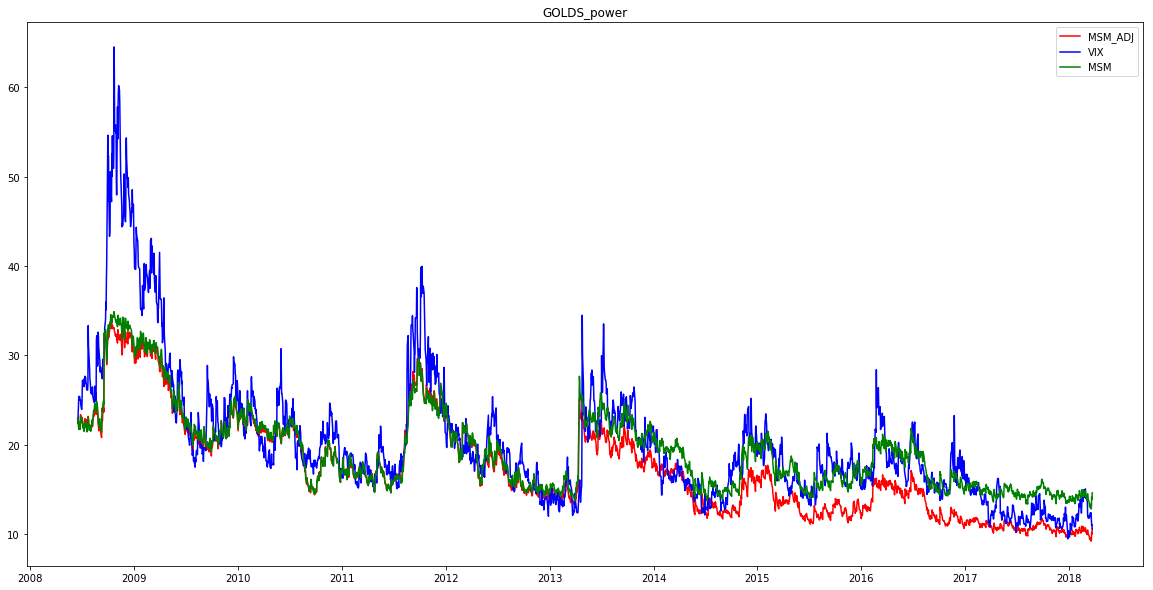

2
                            OLS Regression Results                            
Dep. Variable:                    GVZ   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     9335.
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        14:22:59   Log-Likelihood:                -6873.5
No. Observations:                2550   AIC:                         1.375e+04
Df Residuals:                    2548   BIC:                         1.376e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3999      0.235     -5.955      0

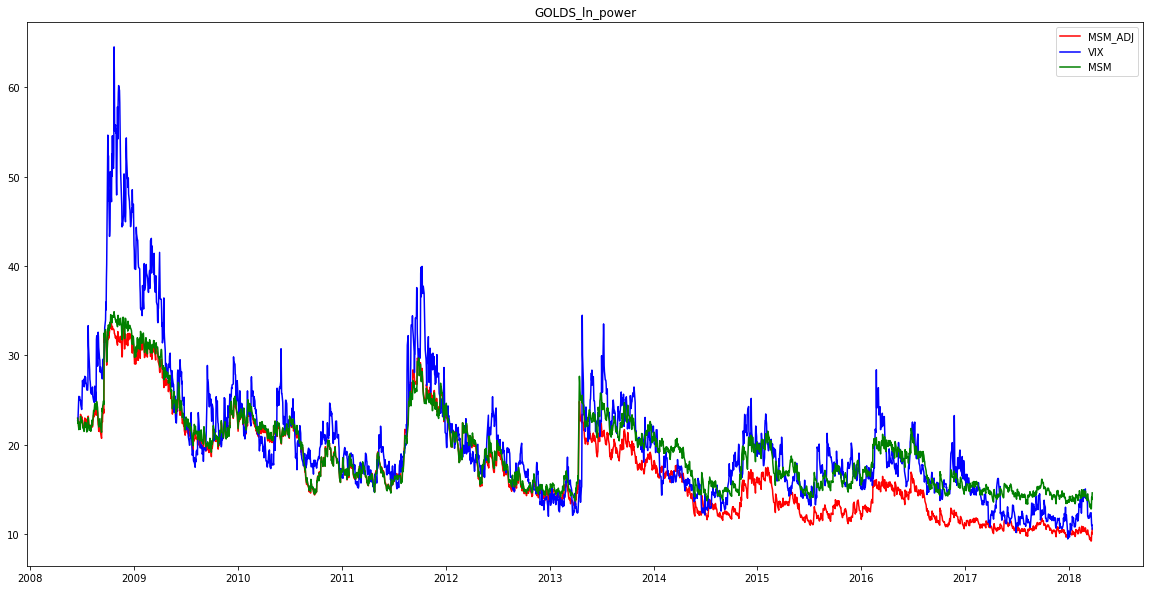

4
                            OLS Regression Results                            
Dep. Variable:                    GVZ   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     9193.
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        14:23:00   Log-Likelihood:                -6888.8
No. Observations:                2550   AIC:                         1.378e+04
Df Residuals:                    2548   BIC:                         1.379e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2481      0.235     -5.303      0

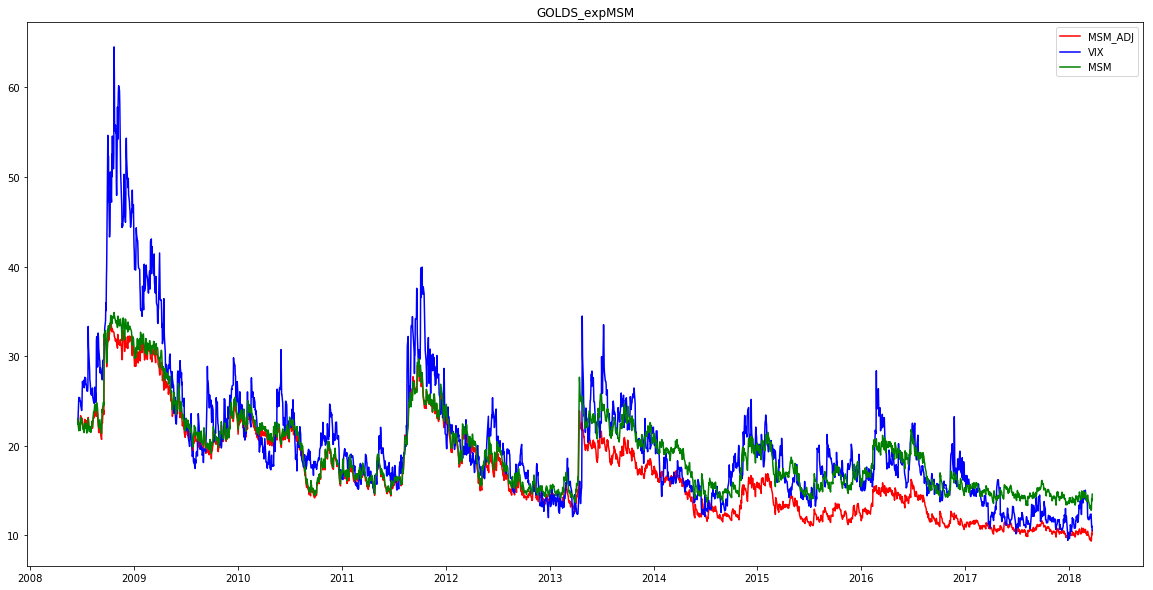

6
                            OLS Regression Results                            
Dep. Variable:                    GVZ   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     9541.
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        14:23:00   Log-Likelihood:                -6851.6
No. Observations:                2550   AIC:                         1.371e+04
Df Residuals:                    2548   BIC:                         1.372e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3520      0.232     -5.825      0

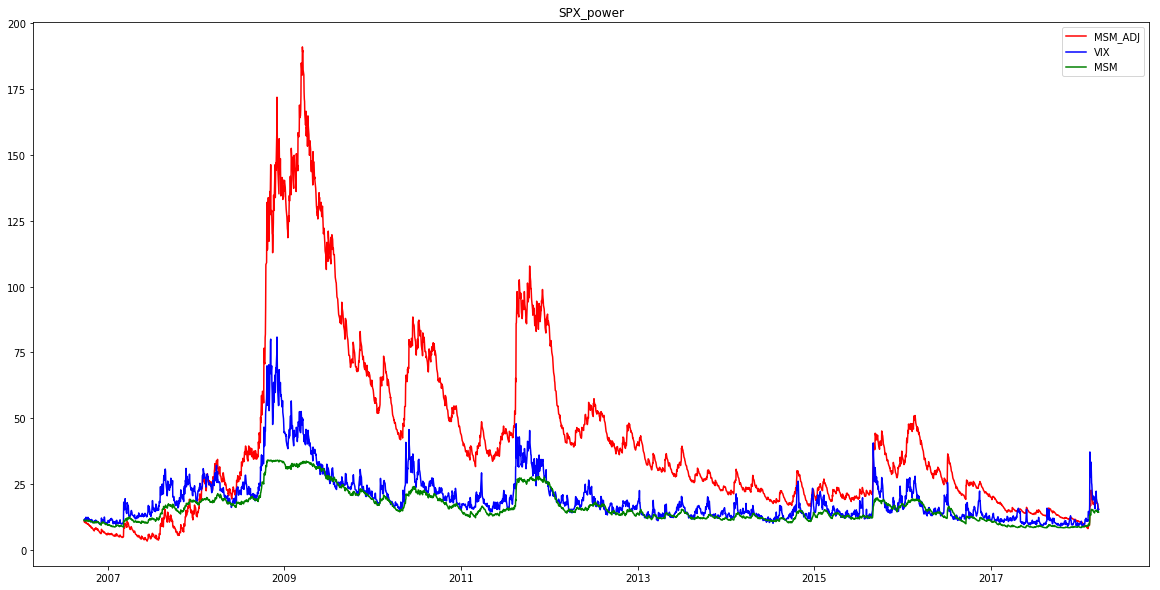

8
                            OLS Regression Results                            
Dep. Variable:                    VIX   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     7025.
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        14:23:01   Log-Likelihood:                -9221.1
No. Observations:                2999   AIC:                         1.845e+04
Df Residuals:                    2997   BIC:                         1.846e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.8680      0.150     65.807      0

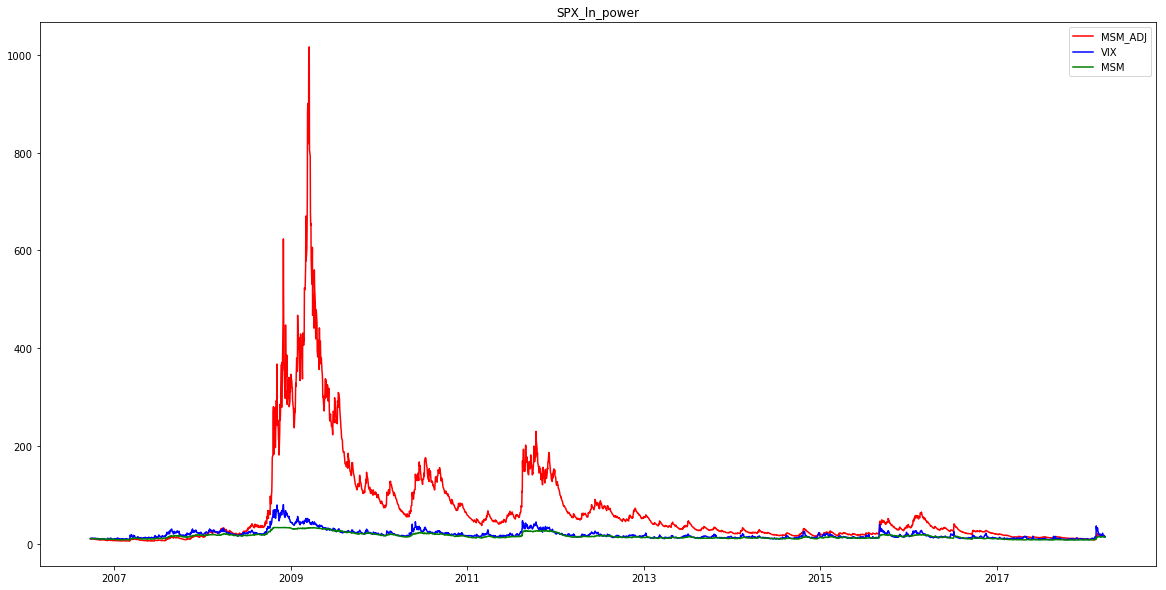

10
                            OLS Regression Results                            
Dep. Variable:                    VIX   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     4519.
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        14:23:02   Log-Likelihood:                -9652.4
No. Observations:                2999   AIC:                         1.931e+04
Df Residuals:                    2997   BIC:                         1.932e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.4682      0.134    108.115      

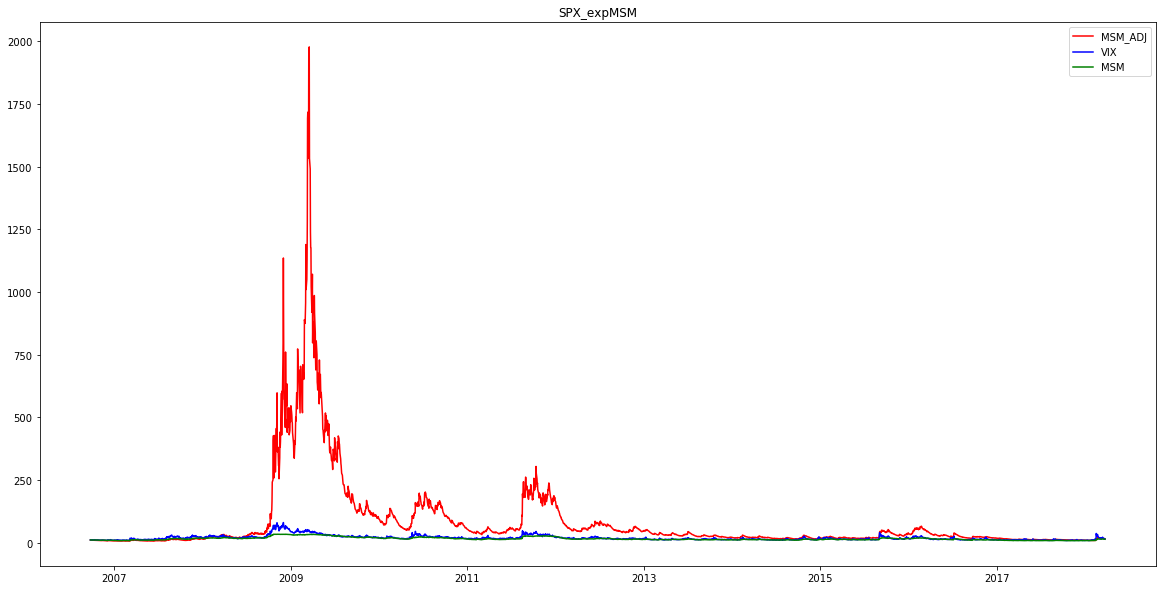

12
                            OLS Regression Results                            
Dep. Variable:                    VIX   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     3531.
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        14:23:03   Log-Likelihood:                -9863.8
No. Observations:                2999   AIC:                         1.973e+04
Df Residuals:                    2997   BIC:                         1.974e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.0113      0.133    120.733      

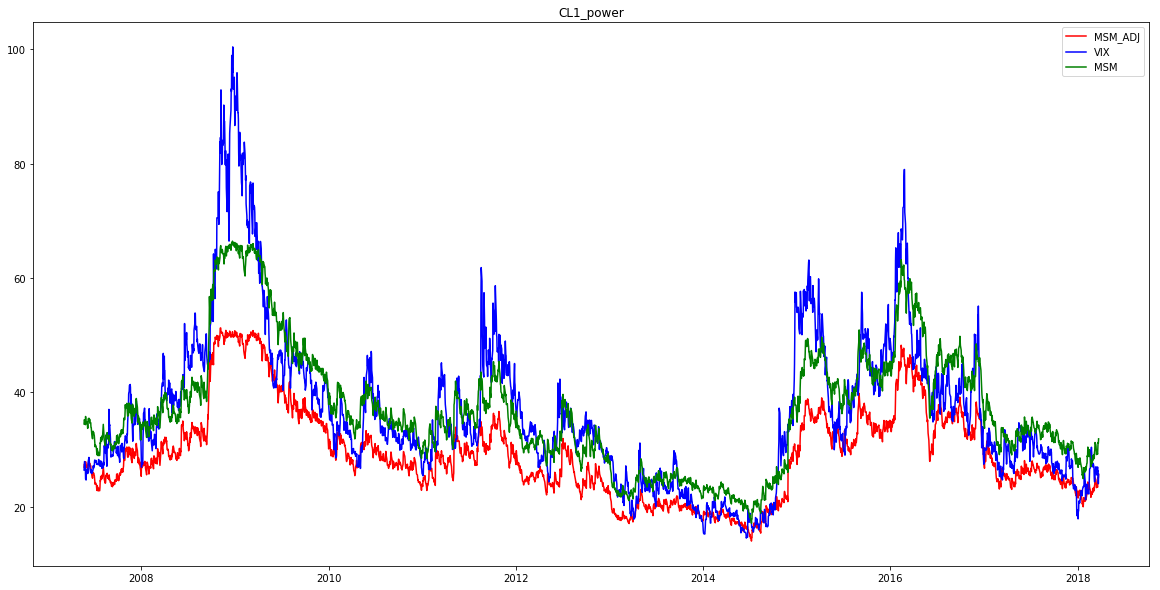

14
                            OLS Regression Results                            
Dep. Variable:                    OVX   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                 1.274e+04
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        14:23:03   Log-Likelihood:                -9016.9
No. Observations:                2828   AIC:                         1.804e+04
Df Residuals:                    2826   BIC:                         1.805e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.0879      0.419    -21.671      

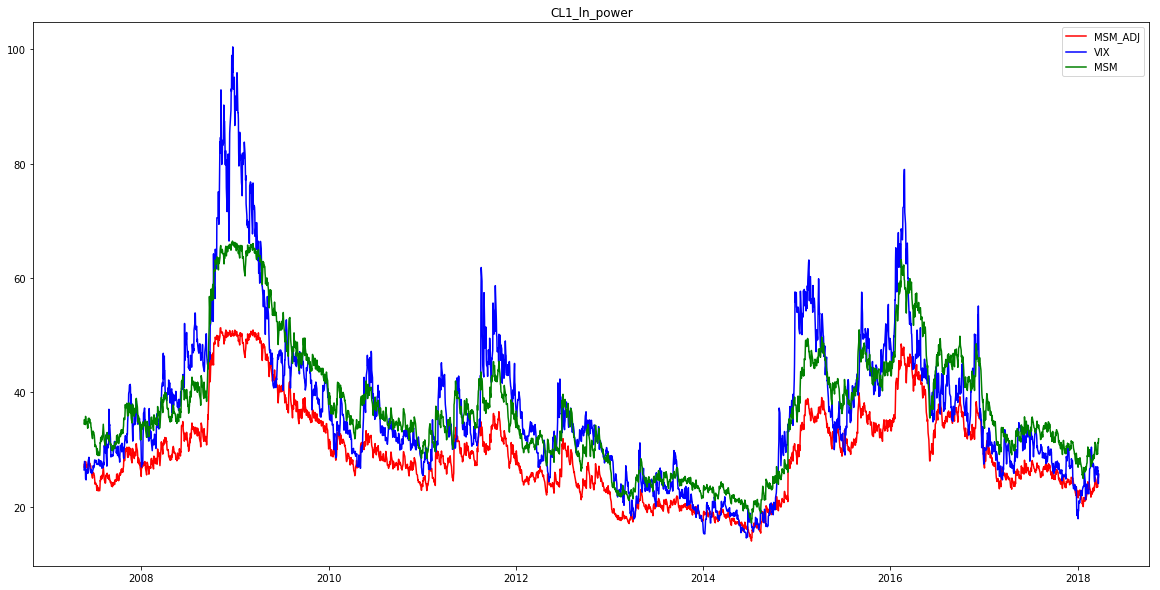

16
                            OLS Regression Results                            
Dep. Variable:                    OVX   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                 1.277e+04
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        14:23:04   Log-Likelihood:                -9013.8
No. Observations:                2828   AIC:                         1.803e+04
Df Residuals:                    2826   BIC:                         1.804e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.9254      0.417    -21.383      

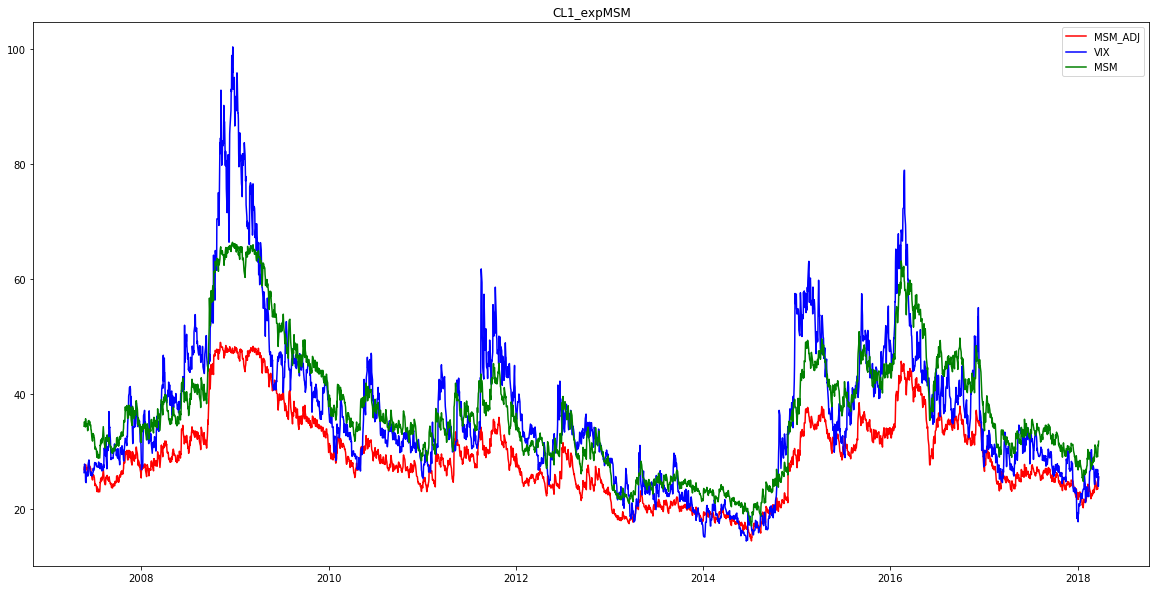

18
                            OLS Regression Results                            
Dep. Variable:                    OVX   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                 1.242e+04
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        14:23:05   Log-Likelihood:                -9045.8
No. Observations:                2828   AIC:                         1.810e+04
Df Residuals:                    2826   BIC:                         1.811e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.6323      0.455    -27.744      

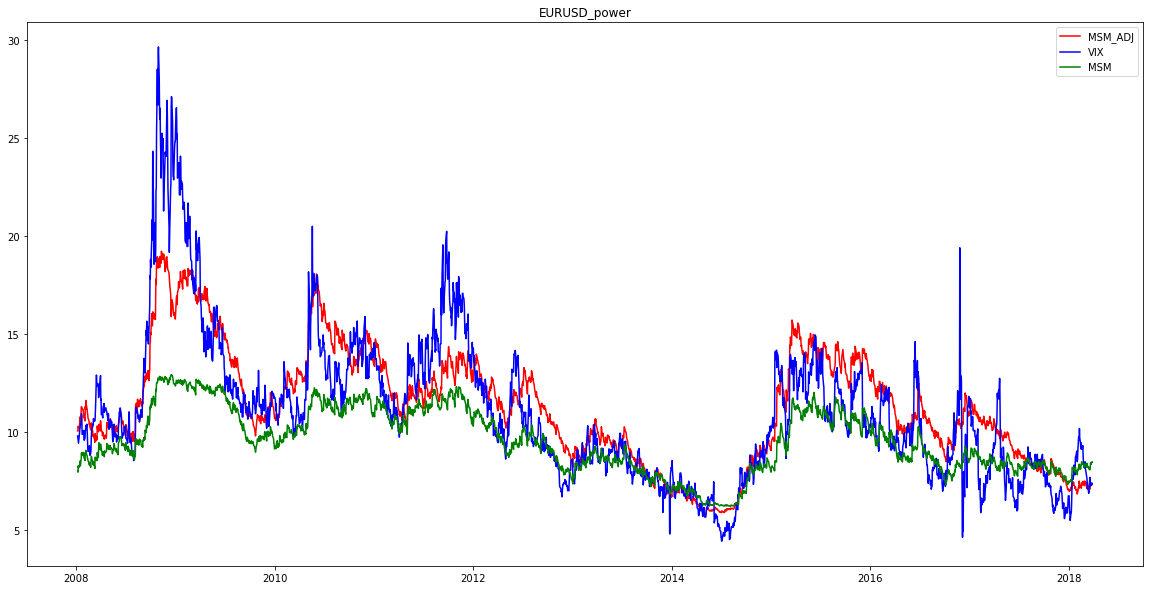

20
                            OLS Regression Results                            
Dep. Variable:                  EUVIX   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     7636.
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        14:23:05   Log-Likelihood:                -5530.9
No. Observations:                2666   AIC:                         1.107e+04
Df Residuals:                    2664   BIC:                         1.108e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6203      0.149    -10.841      

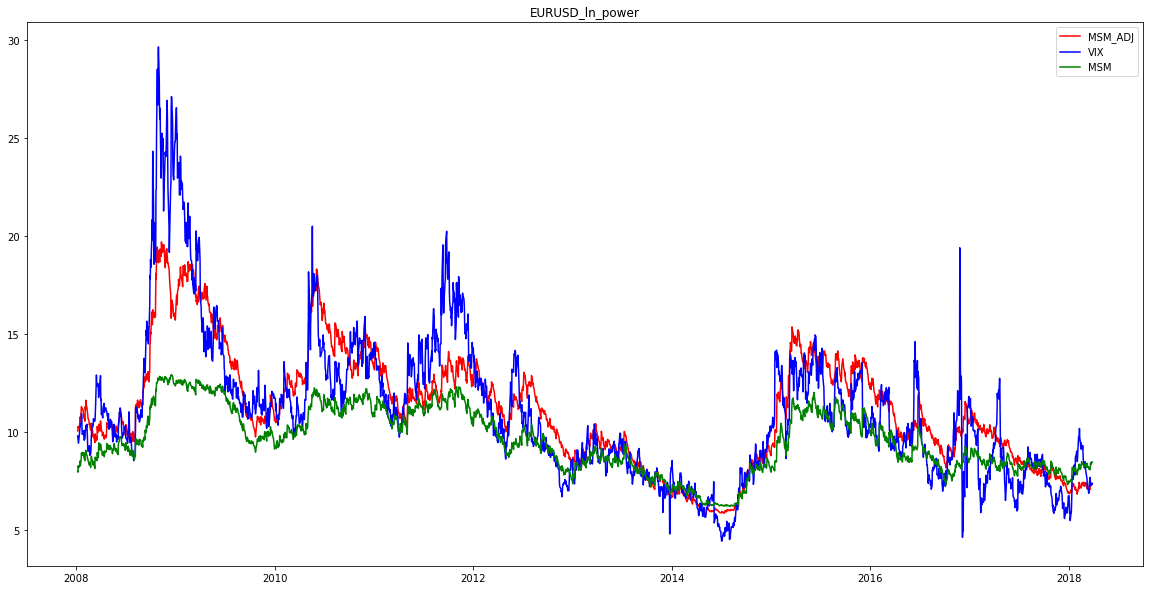

22
                            OLS Regression Results                            
Dep. Variable:                  EUVIX   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     8498.
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        14:23:06   Log-Likelihood:                -5423.7
No. Observations:                2666   AIC:                         1.085e+04
Df Residuals:                    2664   BIC:                         1.086e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4674      0.140    -10.467      

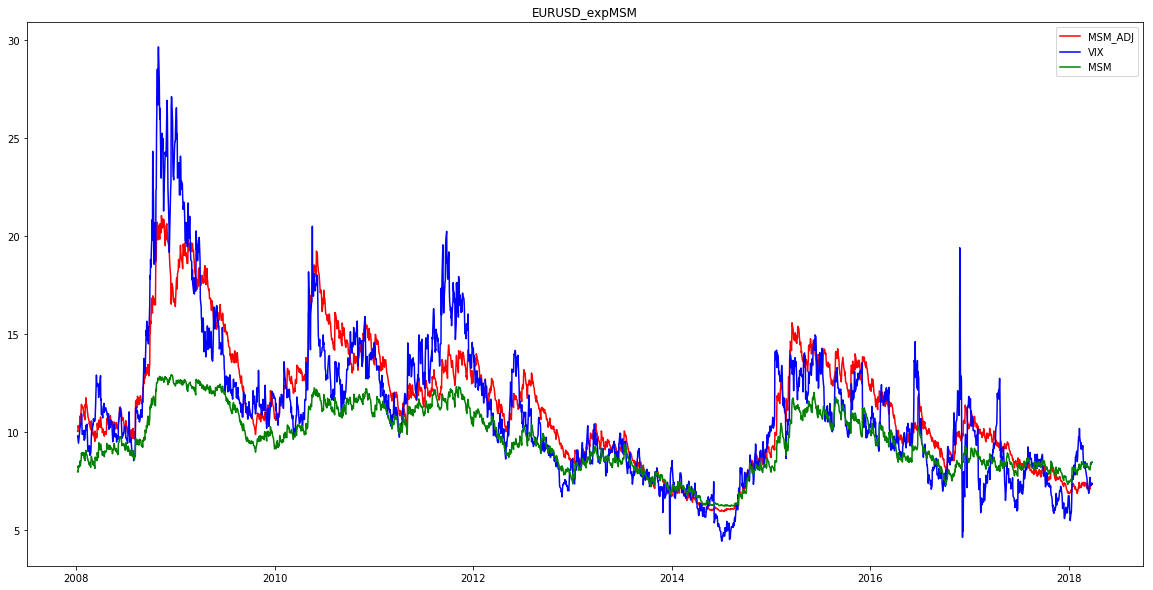

24
                            OLS Regression Results                            
Dep. Variable:                  EUVIX   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     9374.
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        14:23:07   Log-Likelihood:                -5323.0
No. Observations:                2666   AIC:                         1.065e+04
Df Residuals:                    2664   BIC:                         1.066e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8869      0.128     -6.940      

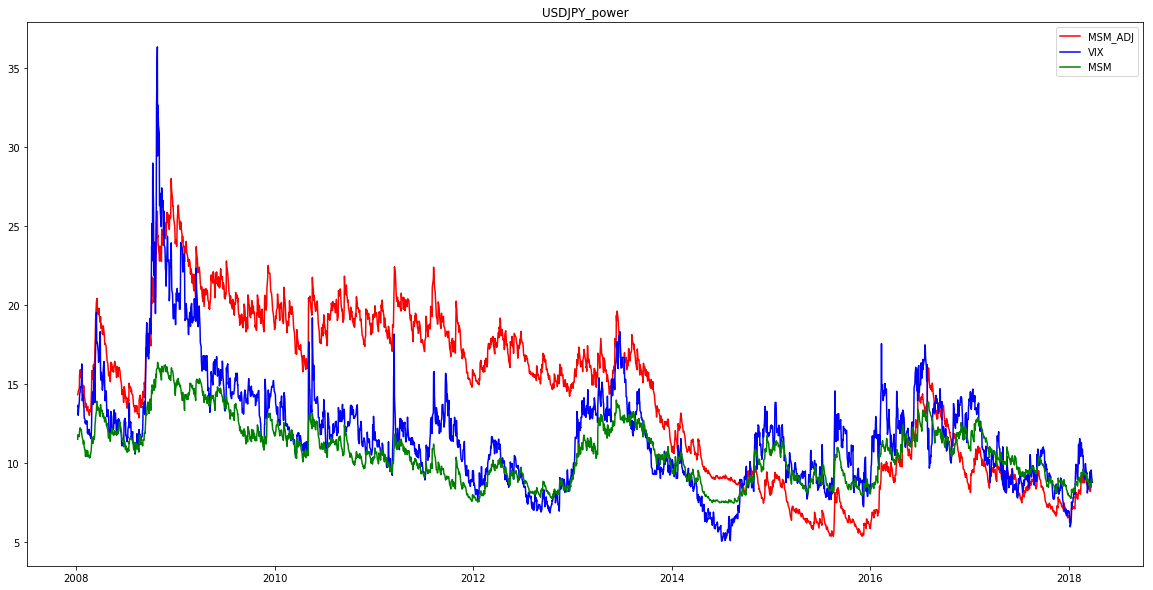

26
                            OLS Regression Results                            
Dep. Variable:                  JYVIX   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     1682.
Date:                Mon, 09 Apr 2018   Prob (F-statistic):          1.96e-285
Time:                        14:23:07   Log-Likelihood:                -6496.3
No. Observations:                2666   AIC:                         1.300e+04
Df Residuals:                    2664   BIC:                         1.301e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6349      0.158     35.595      

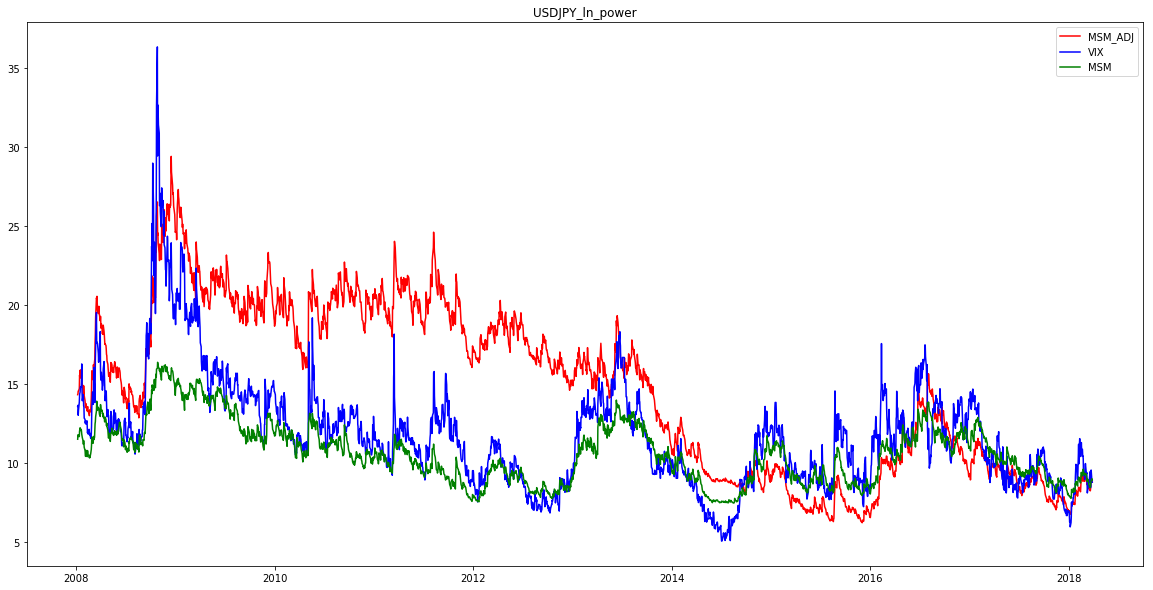

28
                            OLS Regression Results                            
Dep. Variable:                  JYVIX   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     1453.
Date:                Mon, 09 Apr 2018   Prob (F-statistic):          3.76e-254
Time:                        14:23:08   Log-Likelihood:                -6568.4
No. Observations:                2666   AIC:                         1.314e+04
Df Residuals:                    2664   BIC:                         1.315e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8746      0.164     35.927      

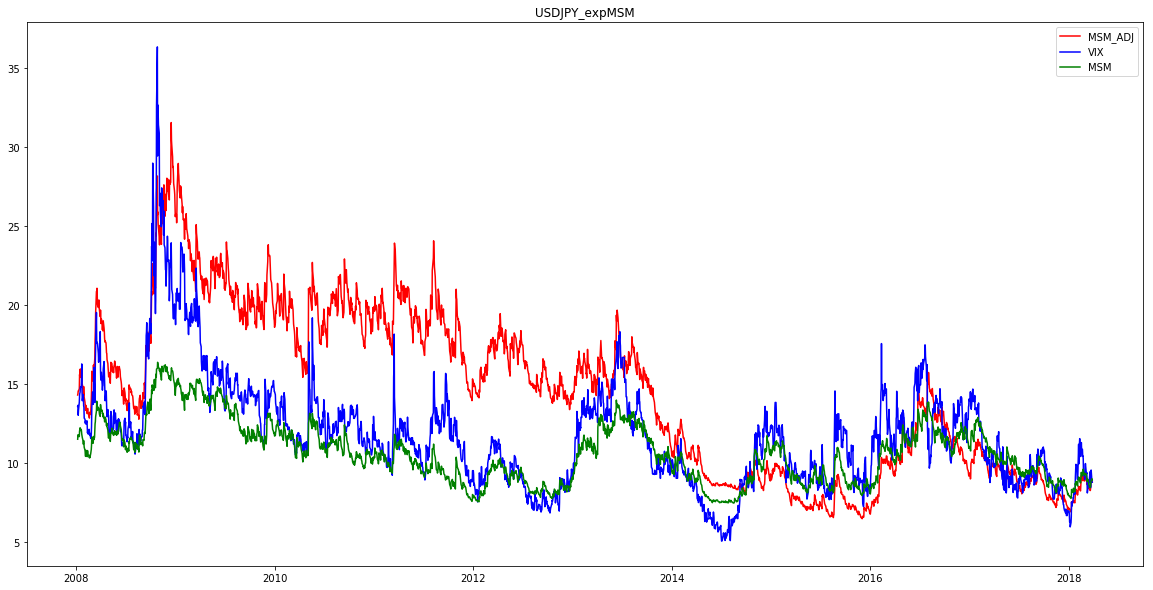

30
                            OLS Regression Results                            
Dep. Variable:                  JYVIX   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     2127.
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        14:23:08   Log-Likelihood:                -6366.4
No. Observations:                2666   AIC:                         1.274e+04
Df Residuals:                    2664   BIC:                         1.275e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1968      0.151     34.446      

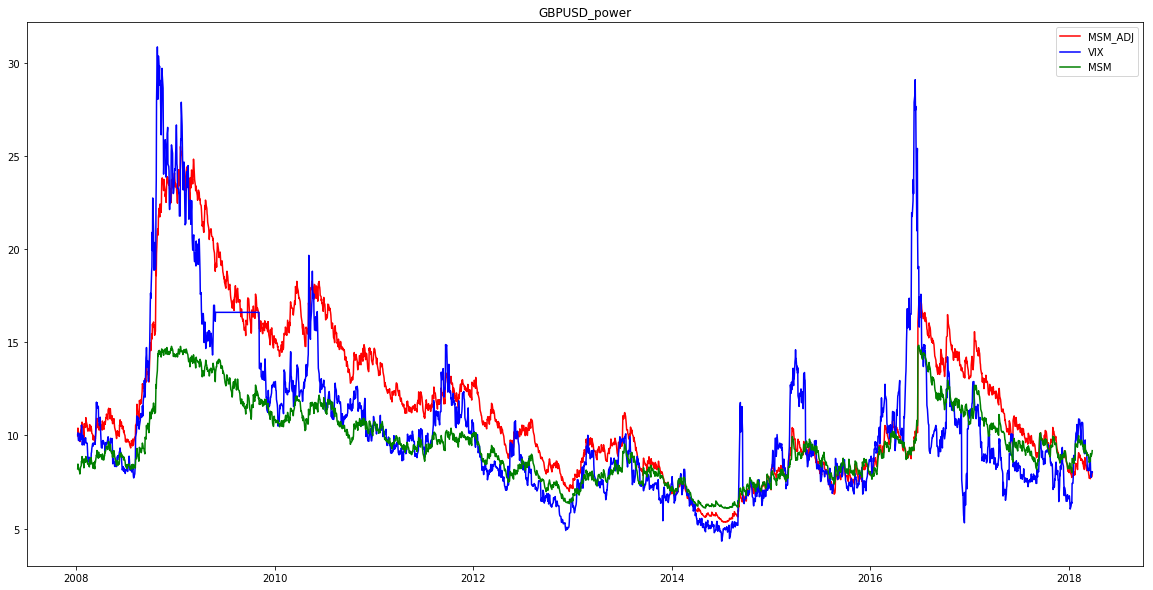

32
                            OLS Regression Results                            
Dep. Variable:                  BPVIX   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     6254.
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        14:23:09   Log-Likelihood:                -6067.0
No. Observations:                2666   AIC:                         1.214e+04
Df Residuals:                    2664   BIC:                         1.215e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5400      0.134      4.044      

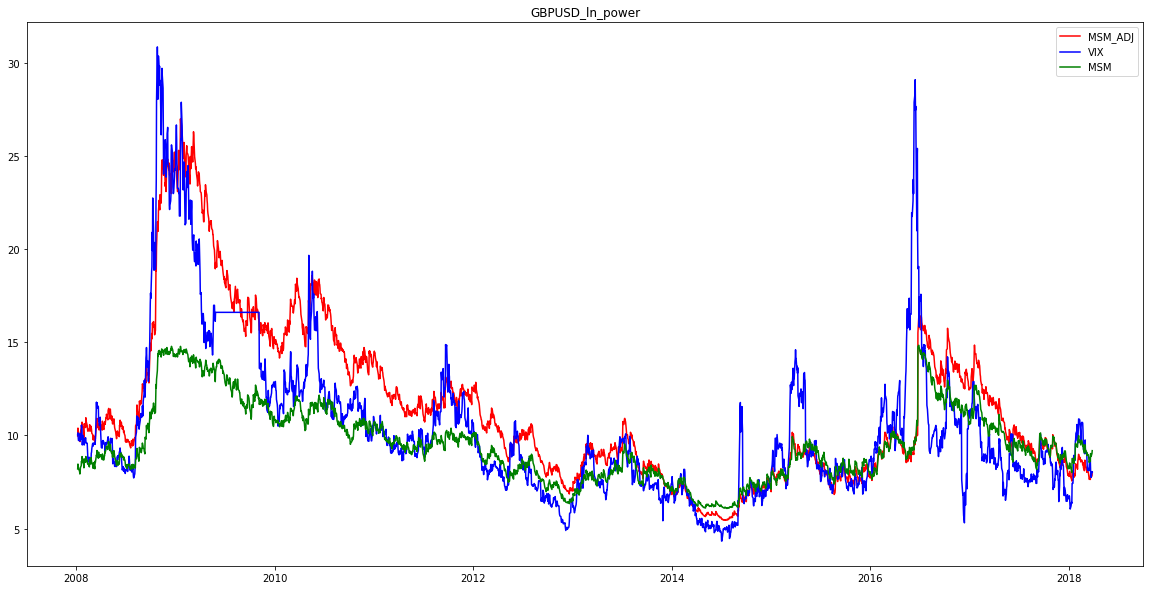

34
                            OLS Regression Results                            
Dep. Variable:                  BPVIX   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     6691.
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        14:23:10   Log-Likelihood:                -6003.3
No. Observations:                2666   AIC:                         1.201e+04
Df Residuals:                    2664   BIC:                         1.202e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8820      0.125      7.037      

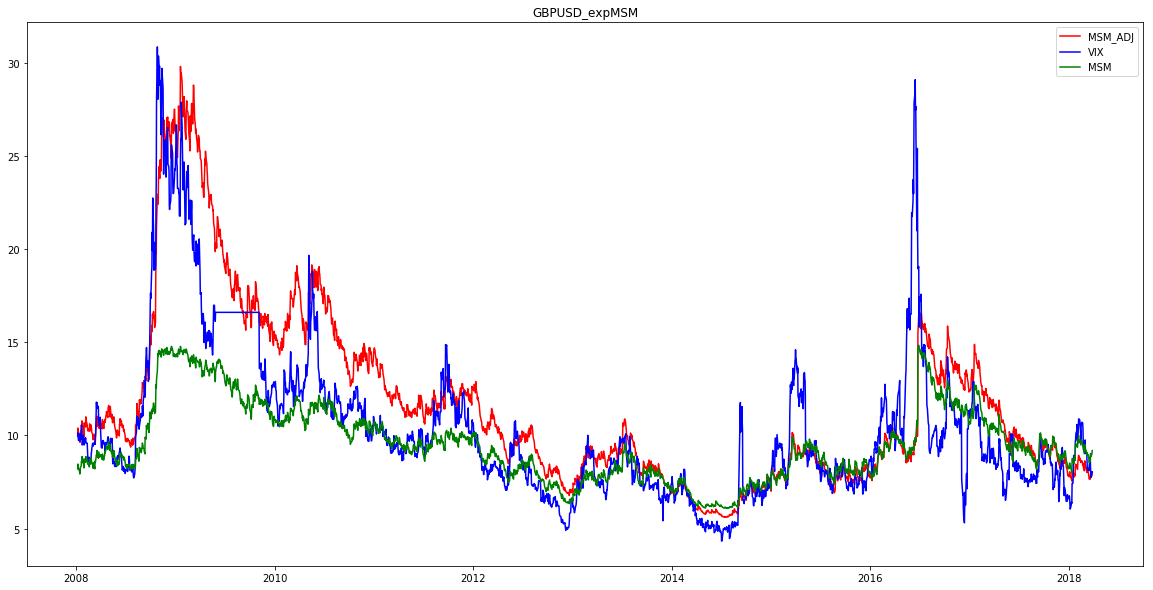

36
                            OLS Regression Results                            
Dep. Variable:                  BPVIX   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     7085.
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        14:23:10   Log-Likelihood:                -5948.3
No. Observations:                2666   AIC:                         1.190e+04
Df Residuals:                    2664   BIC:                         1.191e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5052      0.115     13.084      

In [43]:
count = 0

for i in range(0,len(asset)):
    
    # unbox
    exec( "Data =" + eval("asset["+str(i)+"]") )
    name_asset = asset[i]
    
    x = Data.loc[:,'MSM'].values.reshape(len(Data),1)
    y = Data.iloc[:,0]
    
    #y=mx
    est = sm.OLS(y, x)
    est2 = est.fit()
    print('\n',est2.summary())
    print("MODEL MSE",est2.mse_resid)
    print("MODEL TSE",est2.mse_total)
    
    #save r**2 initial
    rsq_init = est2.rsquared
    
    for j in range(0,len(riskAversion_Function_name)):
        
        name_function = riskAversion_Function_name[j]
        
        dum_Data = Data.copy(deep=True)
        dum_Data['realize_A('+name_function+')'] = 0.
        dum_Data['Diff'] = 0.
        dum_Data['New_Diff'] = 0.
        dum_Data['MSM_ADJ'] = 0.
        
        # 0) calculation
        if j == 0 :
            # power
            dum_Data['realize_A('+name_function+')'] = dum_Data.iloc[:,0]/dum_Data.iloc[:,3]
        elif j ==1 :
            # ln_power
            dum_Data['realize_A('+name_function+')'] = np.log(dum_Data.iloc[:,0]/dum_Data.iloc[:,3])
        elif j==2 :
            # expMSM
            dum_Data['realize_A('+name_function+')'] = np.log(dum_Data.iloc[:,0])/np.log(dum_Data.iloc[:,3])
            
        AA = dum_Data['realize_A('+name_function+')']


        # shift downward
        dum_Data['Diff'] = AA - AA.shift(1)
# CHANGE use log
#         dum_Data['Diff'] = np.log(AA) - np.log(AA.shift(1))
        
        y = dum_Data.loc[1:,"Diff"]#.values.reshape(len(dum_Data),1)
        x = dum_Data.iloc[1:,1]
        
# CAHNGE add const
        # 1) reg y=mx to fit the a for multipliler
        x2 = sm.add_constant(x)
        est = sm.OLS(y, x2)
        est2 = est.fit()
        print('=========='+name_asset+"===========")
        print('\n',est2.summary())
        print("MODEL MSE",est2.mse_resid)
        print("MODEL TSE",est2.mse_total)
# CHANGE THIS ADD CONST
        const = est2.params.values[0]
        slope = est2.params.values[1]
        print(slope)
        print(const)
        # 2) Adjust for DIFF
        dum_Data.loc[:,'New_Diff'] = dum_Data.iloc[:,1]*slope + const
        dum_Data.loc[0,'New_Diff'] = slope
        
        # correct for new approximate DIFF
        # as a realize@[t-1] + approximate_Diff

# CHANGE exp adj
#         new_a = dum_Data.iloc[:,4].shift(1) * np.exp(dum_Data.loc[:,'New_Diff'])
        new_a = dum_Data.iloc[:,4].shift(1) + dum_Data.loc[:,'New_Diff']

# CHANGE use predicted data if want to use old data close this for loop
        for ee in range(2,len(AA)):
# CHANGE exp adj
#             new_a.loc[ee] = new_a.iloc[ee-1] * np.exp(dum_Data.loc[ee,'New_Diff'])
            new_a.loc[ee] = new_a.iloc[ee-1] + dum_Data.loc[ee,'New_Diff']
        
        
        # 3) MSM_adjust

        if j == 0 :
            # power
            dum_Data['MSM_ADJ'] = dum_Data.iloc[:,3] * new_a
        elif j ==1 :
            # ln_power
            dum_Data['MSM_ADJ'] = dum_Data.iloc[:,3] * np.exp(new_a)
        elif j==2 :
            # expMSM
            dum_Data['MSM_ADJ'] = np.power(dum_Data.iloc[:,3],new_a)
            
        # 4) reg and print 
            
        y = dum_Data.iloc[1:,0]#.values.reshape(len(dum_Data),1)
        x = dum_Data.loc[1:,"MSM_ADJ"]
    
        # 1) reg y=mx to fit the a for multipliler
        est = sm.OLS(y, x)
        est2 = est.fit()
        
        count = count +1
        print(count)
        print('=========='+name_function+"===========")
        print(est2.summary())
        print("MODEL MSE : ",est2.mse_resid)
        print("MODEL TSE : ",est2.mse_total)
        print("Marginal R-Sq %2.5f : " %(-rsq_init + est2.rsquared) )
        all_rsq.iloc[j,i+1] = est2.rsquared - rsq_init
        
        plt.figure(figsize=(20,10))
        plt.plot(dum_Data.loc[1:,"Dates"],x,'r',dum_Data.loc[1:,"Dates"],y,'b',
                 dum_Data.loc[1:,"Dates"],dum_Data.loc[1:,"MSM"],'g')
        plt.title(asset[i] +'_'+name_function)
        plt.legend(["MSM_ADJ", "VIX","MSM"])
        plt.show()
        
        
        count = count +1
        print(count)
        x2 = sm.add_constant(x)
        est = sm.OLS(y, x2)
        est2 = est.fit()
        print(est2.summary())
        print("MODEL MSE : ",est2.mse_resid)
        print("MODEL TSE : ",est2.mse_total)
        print("Marginal R-Sq : %2.5f " %(-rsq_init + est2.rsquared) )
        
       
       
        
        
        # save each adj result
#         name_L = 'MSM_adj_vol22'.join((date.today().strftime('%y%m%d'),'_'+name_asset+"_by_"+name_function+'.xlsx'))
#         writer = pd.ExcelWriter(name_L)
#         print(name_L)
#         dum_Data.to_excel(writer, 'Sheet1')
#         writer.save()
        
    name_L = 'All_Marginal_Rsq_MSM_adj'.join((date.today().strftime('%y%m%d'),'.xlsx'))
    writer = pd.ExcelWriter(name_L)
    print(name_L)
    all_rsq.to_excel(writer, 'Sheet1')
    writer.save()
    
        

    

In [28]:
all_rsq

,method,GOLDS,SPX,CL1,EURUSD,USDJPY,GBPUSD
0,power,0.0267206,0.0361339,0.0215836,0.0386876,0.0225778,0.0591809
1,ln_power,0.0267048,0.0349814,0.0215809,0.0386768,0.0226537,0.0591293
2,expMSM,0.02664,0.0327987,0.0215598,0.0386324,0.0226115,0.0587648
4,File_name,180329MSM_vol22_GOLDS3000_Normal(1)_predict=[2...,180329MSM_vol22_SPX3000_Normal(1)_predict=[22]...,180329MSM_vol22_CL13000_Normal(1)_predict=[22]...,180329MSM_vol22_EURUSD3000_Normal(1)_predict=[...,180329MSM_vol22_USDJPY3000_Normal(1)_predict=[...,180329MSM_vol22_GBPUSD3000_Normal(1)_predict=[...


In [89]:
est2.rsquared

0.03262668555253323

In [95]:
new

0            NaN
1      -0.183366
2       0.146365
3      -0.748665
4       0.154521
5      -0.249913
6      -0.037808
7       0.346796
8       0.043502
9       0.406299
10     -0.816398
11     -0.620717
12      0.882733
13     -0.276983
14      1.076452
15      0.333014
16      0.058995
17      0.257598
18     -0.156212
19      0.051825
20     -1.120807
21      0.423999
22     -0.430649
23     -0.167478
24     -0.979567
25      0.178530
26      0.253936
27      0.459372
28      0.151142
29      0.312599
          ...   
2637    0.399473
2638    0.748728
2639    0.714826
2640   -0.518030
2641   -0.185375
2642   -0.025315
2643   -0.560452
2644    0.272029
2645    0.107548
2646   -0.019006
2647   -0.417005
2648   -1.077706
2649    0.115111
2650    0.186573
2651    0.338311
2652    0.280877
2653    0.061167
2654   -0.615211
2655    0.279631
2656    0.401172
2657    0.401895
2658    0.001046
2659   -0.179427
2660    0.032448
2661    0.587511
2662   -0.191499
2663    1.018251
2664   -0.3202

In [94]:
dum_Data

,BPVIX,GBPUSD,Dates,MSM,realize_A(expMSM),Diff,New_Diff,MSM_ADJ
0,10.16,-0.182537,2008-01-07,8.338765,1.093141,NaN,-0.005834,NaN
1,10.05,0.142002,2008-01-08,8.201631,1.096581,0.003441,-0.000829,0.679864
2,10.14,-0.747772,2008-01-09,8.465550,1.084496,-0.012086,0.004363,1.367025
3,9.87,0.153061,2008-01-10,8.339940,1.079415,-0.005081,-0.000893,0.204342
4,9.73,-0.250121,2008-01-11,8.251763,1.078082,-0.001333,0.001459,1.385560
5,9.74,-0.035783,2008-01-14,8.100868,1.088084,0.010002,0.000209,0.592852
6,9.80,0.347063,2008-01-15,8.080775,1.092317,0.004232,-0.002025,0.924041
7,9.70,0.045845,2008-01-16,7.933991,1.097033,0.004716,-0.000267,2.050878
8,10.10,0.401515,2008-01-17,7.962580,1.114608,0.017575,-0.002343,1.094454
9,9.81,-0.819990,2008-01-18,8.272361,1.080686,-0.033922,0.004784,2.359567


In [69]:
AA = dum_Data['realize_A('+name_function+')']

In [90]:
np.exp(2)

7.3890560989306504